# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as colors

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [3]:
def dist_vs_idx_dist(com_arr):
    sep_mat = np.linalg.norm(com_arr[:, np.newaxis, :] - com_arr[np.newaxis, :, :], axis=2)
    avg_dist_arr = np.zeros((sep_mat.shape[0]))
    avg_dist_sem_arr = np.zeros((sep_mat.shape[0]))
    for i in range(1,sep_mat.shape[0]):
        diag = np.diagonal(sep_mat, i)
        avg_dist_arr[i] = diag.mean()
        avg_dist_sem_arr[i] = stats.sem(diag)
    return avg_dist_arr, avg_dist_sem_arr
    

def sd_num(h5_data):
    ydict = yaml.safe_load(h5_data.attrs['RunConfig'])
    return ydict['rngSeed']

# Single snapshot clusters

number of estimated clusters : 4
number of thresholded clusters : 3


(<Figure size 1296x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:ylabel='Z ($\\mu$m)'>,
        <AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:xlabel='X ($\\mu$m)', ylabel='Z ($\\mu$m)'>],
       dtype=object))

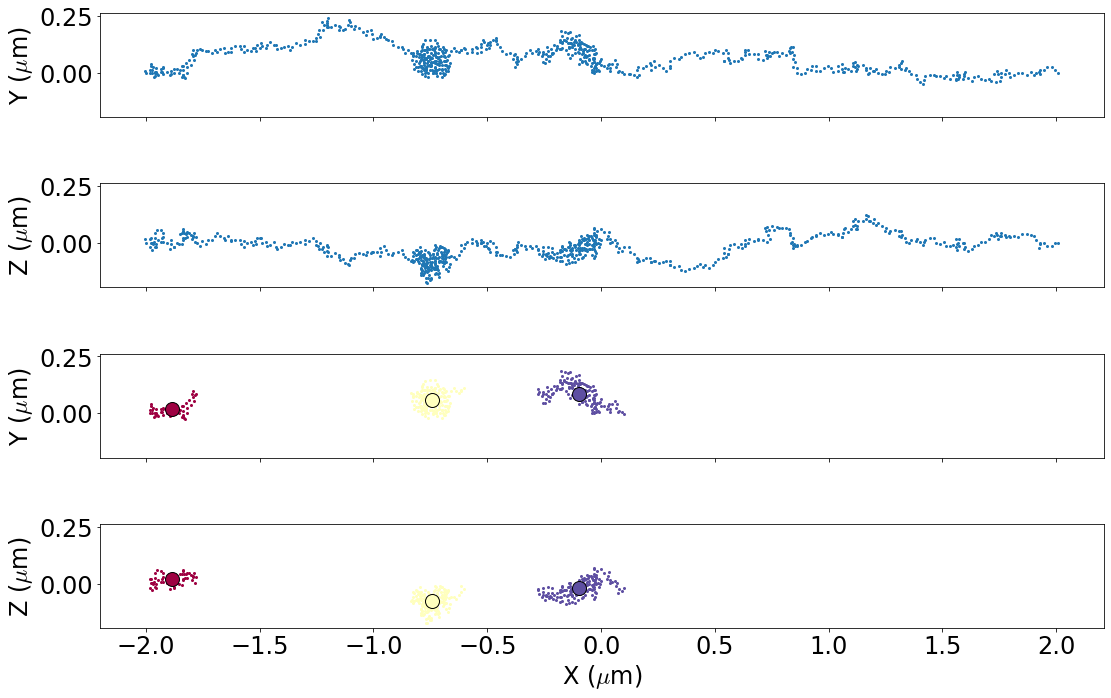

In [5]:
data_path = (ceph_path /"21_aLchr1_700_runs/21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations/s10")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr[:, :, -1], eps=.07, min_samples=20)
    
    
    cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)
   
  

number of estimated clusters : 7
number of thresholded clusters : 5


(<Figure size 1296x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:ylabel='Z ($\\mu$m)'>,
        <AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:xlabel='X ($\\mu$m)', ylabel='Z ($\\mu$m)'>],
       dtype=object))

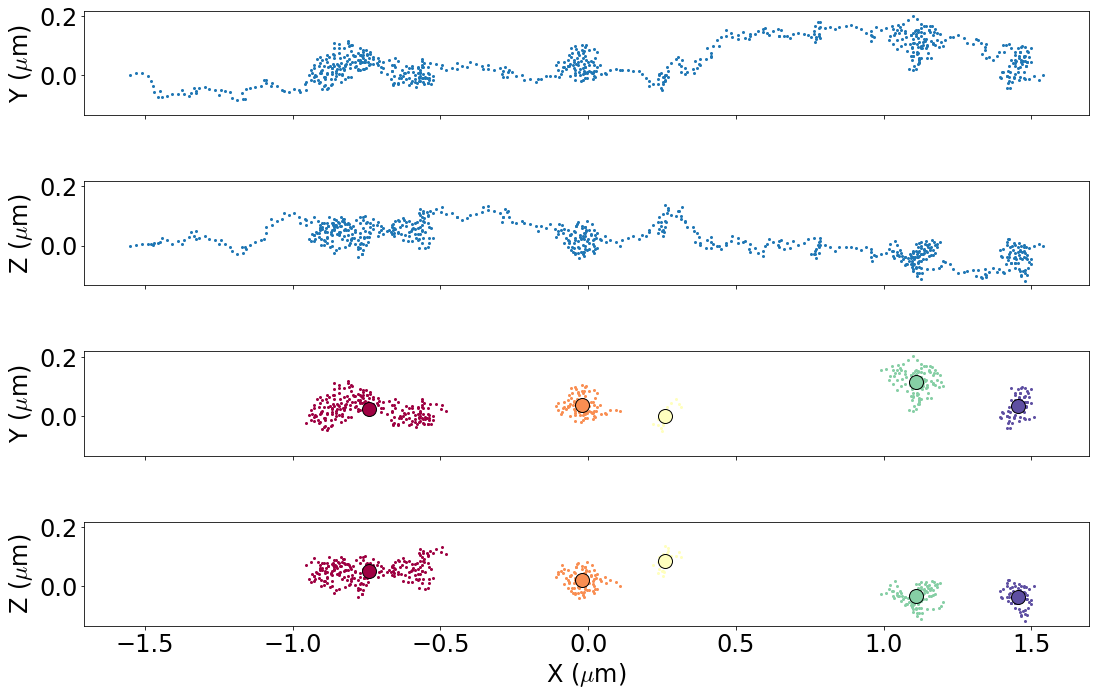

In [9]:
data_path = (ceph_path /"21_aLchr1_700_runs/21-12-05_aLchr1_scan.12_line700_2xsticky_3umconf/simulations/s10")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

   
fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    # clust, cluster_centers, cluster_label_inds = aac.chromatin_condensate_analysis.identify_spatial_clusters(
    #     com_arr[:, :, -1])
    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr[:, :, 500], eps=.05, min_samples=12)
    
    cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,500], clust, cluster_centers, cluster_label_inds)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

number of estimated clusters : 9
number of thresholded clusters : 5


(<Figure size 1296x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:ylabel='Z ($\\mu$m)'>,
        <AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:xlabel='X ($\\mu$m)', ylabel='Z ($\\mu$m)'>],
       dtype=object))

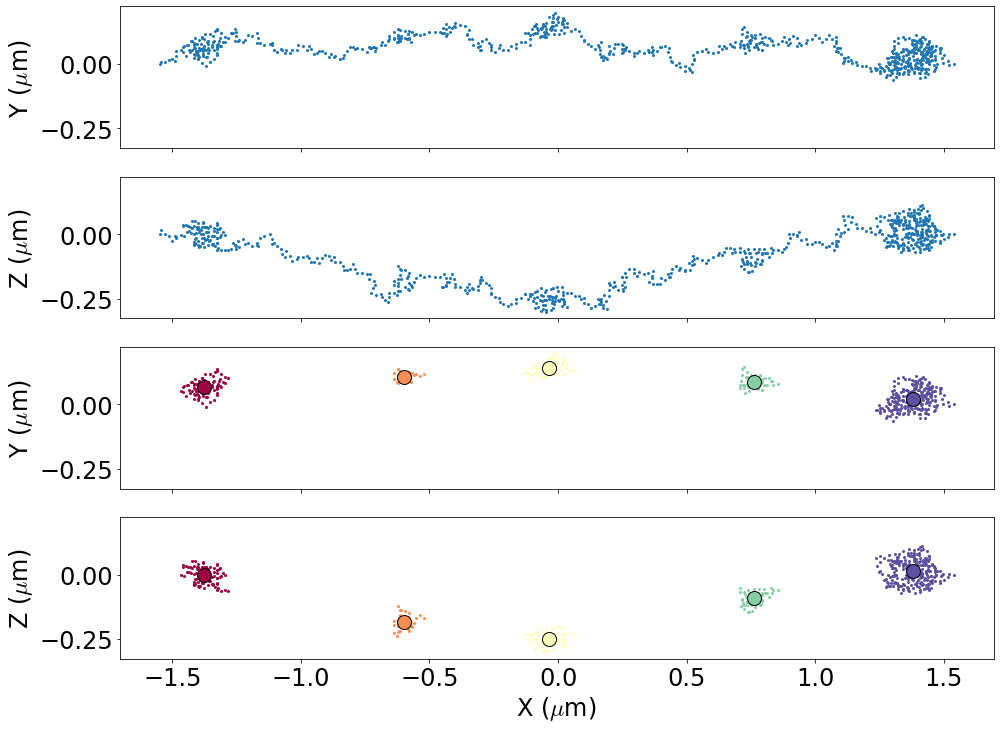

In [11]:
data_path = (ceph_path /"21_aLchr1_700_runs/21-12-05_aLchr1_scan.12_line700_2xsticky_3umconf/simulations/s10")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    # clust, cluster_centers, cluster_label_inds = aac.chromatin_condensate_analysis.identify_spatial_clusters(
    #     com_arr[:, :, -1])
    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr[:, :, -1], eps=.05, min_samples=12)
    
    cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



number of estimated clusters : 8
number of thresholded clusters : 2


(<Figure size 1296x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:ylabel='Z ($\\mu$m)'>,
        <AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:xlabel='X ($\\mu$m)', ylabel='Z ($\\mu$m)'>],
       dtype=object))

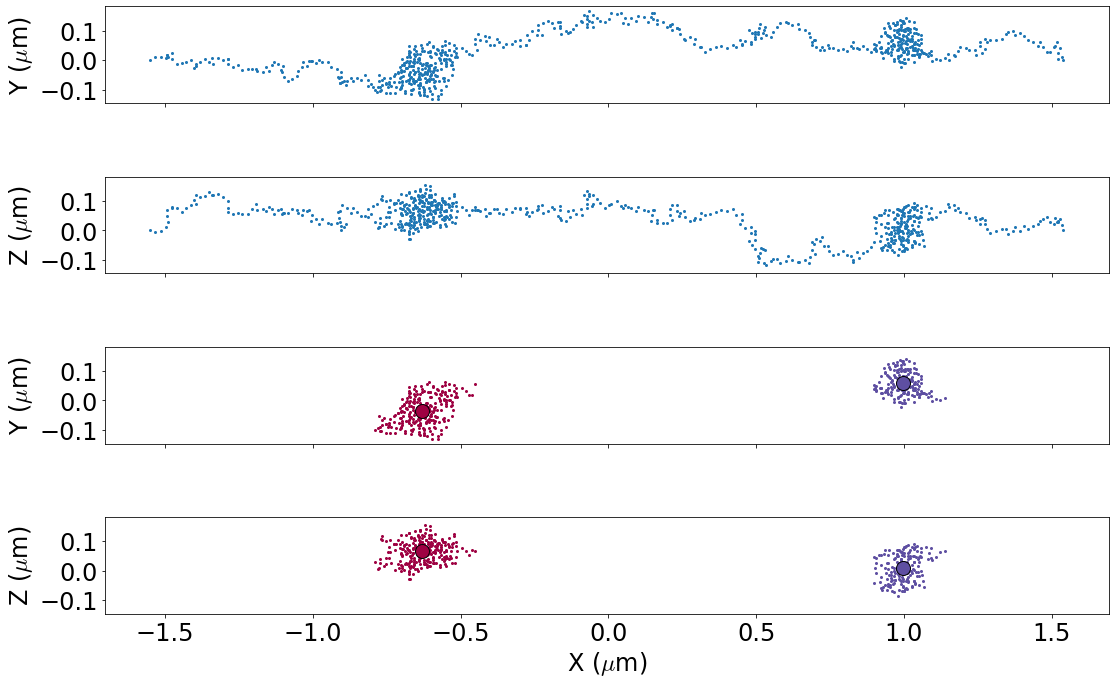

In [12]:
data_path = (
    ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr[:, :, -1],eps=.05, min_samples=12)
    
    
    cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



number of estimated clusters : 6
number of thresholded clusters : 4


(<Figure size 1296x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:ylabel='Z ($\\mu$m)'>,
        <AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:xlabel='X ($\\mu$m)', ylabel='Z ($\\mu$m)'>],
       dtype=object))

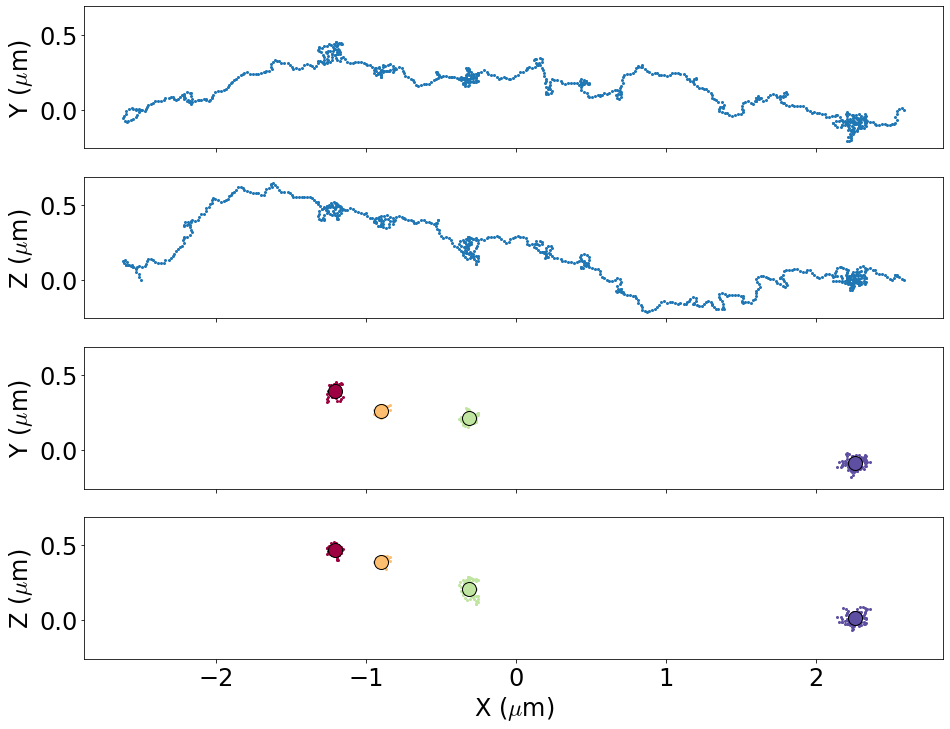

In [13]:
data_path = (
    ws_path / "22-04-01_aLchr1_scan.12_line700_2xsticky_rigid700_5umconf/simulations/s4")
ss_ind = 1
end_ind = 100
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr[:, :, -1], eps=.05, min_samples=12)
    
    
    cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



number of estimated clusters : 7
number of thresholded clusters : 2


(<Figure size 1296x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:ylabel='Z ($\\mu$m)'>,
        <AxesSubplot:ylabel='Y ($\\mu$m)'>,
        <AxesSubplot:xlabel='X ($\\mu$m)', ylabel='Z ($\\mu$m)'>],
       dtype=object))

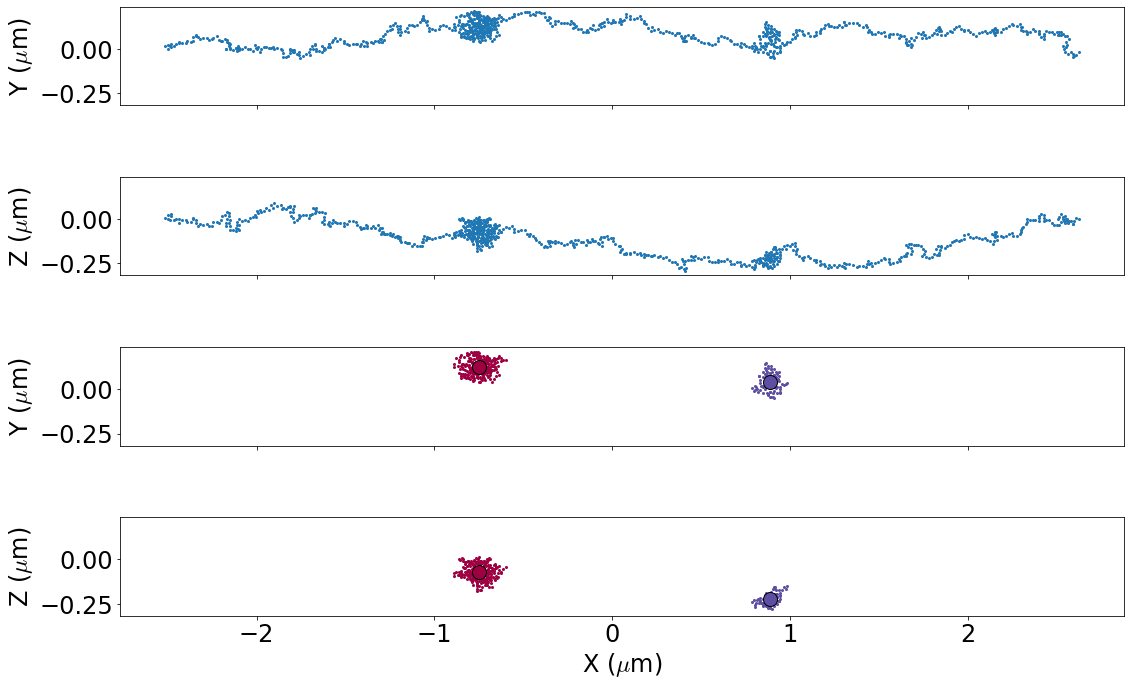

In [14]:
data_path = (
    ws_path / "22-04-28_aLchr1_scan.12_line800_sticky55nm_eps1_Ka30_5umconf/simulations/s6")
ss_ind = 1
end_ind = 500
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr[:, :, -1], eps=.05, min_samples=12)
    
    
    cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



In [ ]:
data_path = (
    ws_path / "22-04-28_aLchr1_scan.12_line800_sticky55nm_eps1_Ka30_5umconf/simulations/s6")
ss_ind = 1
end_ind = 500
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    eps = np.arange(.025, .105, .005)
    min_sample = np.arange(4, 52, 2)
    clust_num_mat = np.zeros((eps.size, min_sample.size))
    beads_in_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_bead_per_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_rog_mat = np.zeros((eps.size, min_sample.size))
    X, Y = np.meshgrid(eps, min_sample)
    for i, e in enumerate(eps):
        for j, m in enumerate(min_sample):
            print(f"i={i}, j={j}")
            clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
                com_arr[:, :, -1], eps=e, min_samples=m, thresh=12, verbose=False)
            clust_num_mat[i,j] = len(cluster_centers)
            beads_in_clust_mat[i,j] = sum([len(cli) for cli in cluster_label_inds])
            avg_bead_per_clust_mat[i,j] = np.mean([len(cli) for cli in cluster_label_inds])
            #avg_rog_mat[i,j] = 
    
    # axarr[0].pcolor(X,Y,clust_num_mat.T)
    # axarr[0].pcolor(X,Y,clust_num_mat.T)
    # axarr[0].pcolor(X,Y,clust_num_mat.T)
            
   # cgf.graph_clust_snapshot(axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



# DBSCAN characterization

/tmp/ipykernel_2989521/476715665.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
/tmp/ipykernel_2989521/476715665.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
/tmp/ipykernel_2989521/476715665.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilater

Text(0.5, 1.0, '# of clusters')

Text(0.5, 1.0, '# of Beads in clusters')

Text(0.5, 1.0, 'Avg # of beads per cluster')

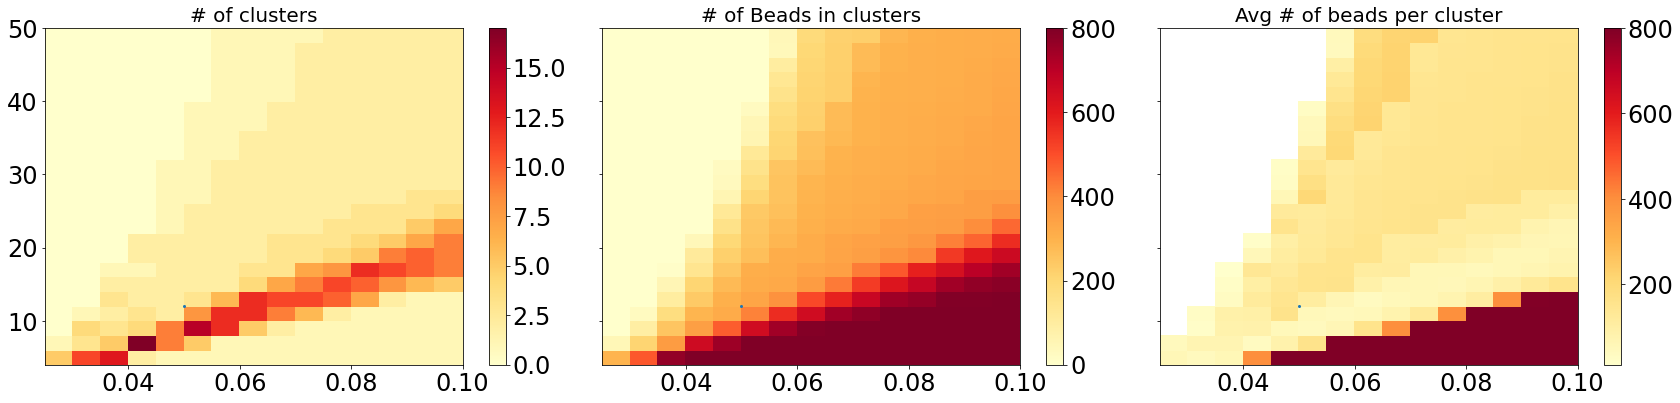

In [41]:
data_path = (
    ws_path / "22-04-28_aLchr1_scan.12_line800_sticky55nm_eps1_Ka30_5umconf/simulations/s6")
ss_ind = 1
end_ind = 500
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(1, 3, figsize=(24, 6), sharex=True, sharey=True)

# axarr[0].set_aspect(True)
    
c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
c2 = axarr[2].pcolor(X,Y, avg_bead_per_clust_mat.T)
cbar0 = fig.colorbar(c0, ax=axarr[0])
cbar1 = fig.colorbar(c1, ax=axarr[1])
cbar2 = fig.colorbar(c2, ax=axarr[2])
axarr[0].set_title(f'# of clusters')
axarr[1].set_title(f'# of Beads in clusters')
axarr[2].set_title(f'Avg # of beads per cluster')
for ax in axarr:
    ax.scatter(.05, 12)
            
   # cgf.graph_clust_snapshot(axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



In [ ]:
data_path = (
    ws_path / "22-04-28_aLchr1_scan.12_line800_sticky55nm_eps1_Ka30_5umconf/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(2, 2, figsize=(24, 12), sharex=True, sharey=True)
axarr = axarr.flatten()
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    eps = np.arange(.025, .105, .005)
    min_sample = np.arange(4, 52, 2)
    clust_num_mat = np.zeros((eps.size, min_sample.size))
    beads_in_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_bead_per_clust_mat = np.zeros((eps.size, min_sample.size))
    avg_rog_mat = np.zeros((eps.size, min_sample.size))
    for i, e in enumerate(eps):
        for j, m in enumerate(min_sample):
            print(f"i={i}, j={j}")
            clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
                com_arr[:, :, -1], eps=e, min_samples=m, thresh=12, verbose=False)
            clust_num_mat[i,j] = len(cluster_centers)
            beads_in_clust_mat[i,j] = sum([len(cli) for cli in cluster_label_inds])
            avg_bead_per_clust_mat[i,j] = np.mean([len(cli) for cli in cluster_label_inds])
            avg_rog_mat[i,j] = np.mean([ca.calc_rad_of_gyration(com_arr[cli,:,end_ind,np.newaxis])/np.cbrt(len(cli)) for cli in cluster_label_inds]) 

    
X, Y = np.meshgrid(eps-.0025, min_sample-1)
c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
c2 = axarr[2].pcolor(X,Y, avg_bead_per_clust_mat.T)
c3 = axarr[3].pcolor(X,Y, avg_rog_mat.T)
cbar0 = fig.colorbar(c0, ax=axarr[0])
cbar1 = fig.colorbar(c1, ax=axarr[1])
cbar2 = fig.colorbar(c2, ax=axarr[2])
cbar3 = fig.colorbar(c3, ax=axarr[3])
_ = axarr[0].set_title(f'# of clusters')
_ = axarr[1].set_title(f'# of Beads in clusters')
_ = axarr[2].set_title(f'Avg # of beads per cluster')
_ = axarr[3].set_title(f'Avg cluster ROG/cluster bead #')
for ax in axarr:
    _ = ax.scatter(.05, 12, s=40, marker='x')
    _ = ax.set_xlabel('Scan radius ($\mu$m)')
    _ = ax.set_ylabel('Minimum neighbors')



/tmp/ipykernel_2989521/3011723574.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
/tmp/ipykernel_2989521/3011723574.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
/tmp/ipykernel_2989521/3011723574.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrila

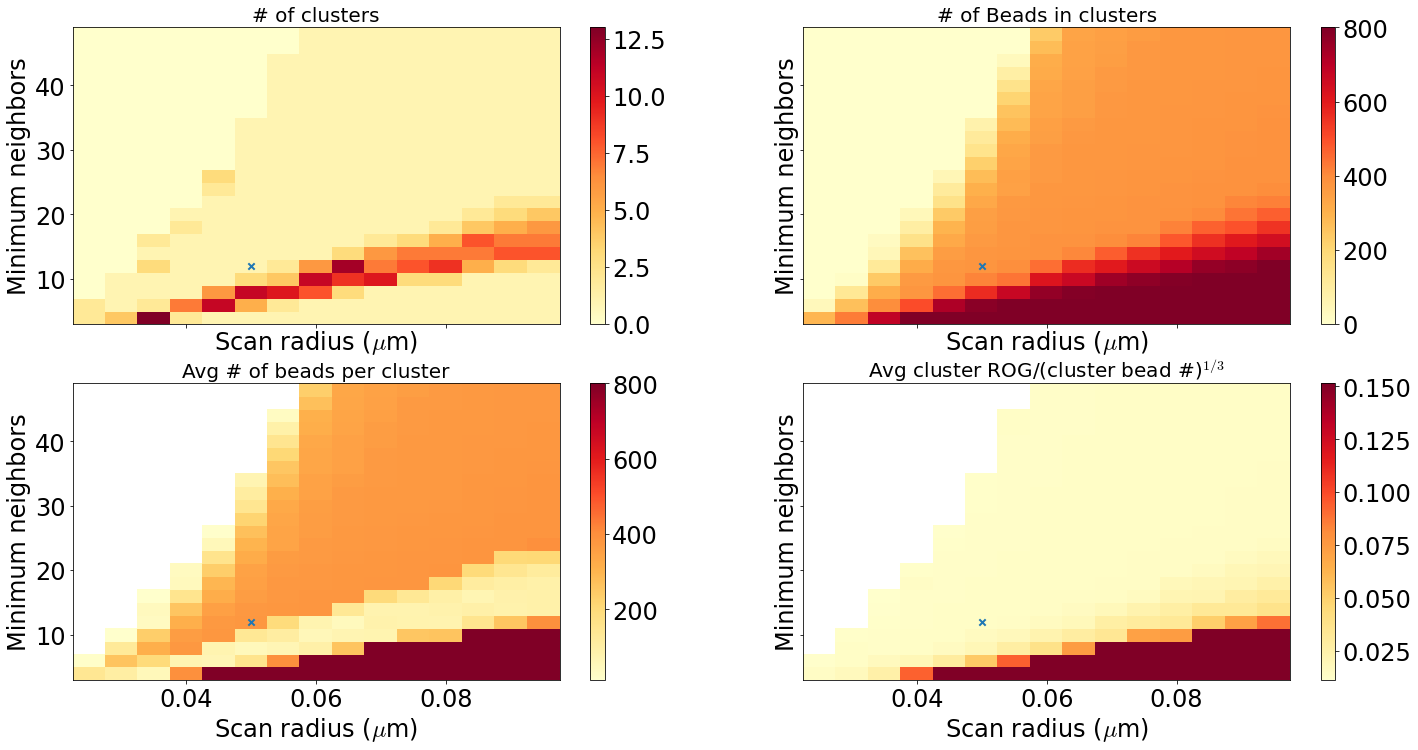

In [65]:
data_path = (
    ws_path / "22-04-28_aLchr1_scan.12_line800_sticky55nm_eps1_Ka30_5umconf/simulations/s6")
ss_ind = 1
end_ind = 500
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(2, 2, figsize=(24, 12), sharex=True, sharey=True)
axarr = axarr.flatten()

X, Y = np.meshgrid(eps-.0025, min_sample-1)
c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
c2 = axarr[2].pcolor(X,Y, avg_bead_per_clust_mat.T)
c3 = axarr[3].pcolor(X,Y, avg_rog_mat.T)
cbar0 = fig.colorbar(c0, ax=axarr[0])
cbar1 = fig.colorbar(c1, ax=axarr[1])
cbar2 = fig.colorbar(c2, ax=axarr[2])
cbar3 = fig.colorbar(c3, ax=axarr[3])
_ = axarr[0].set_title(f'# of clusters')
_ = axarr[1].set_title(f'# of Beads in clusters')
_ = axarr[2].set_title(f'Avg # of beads per cluster')
_ = axarr[3].set_title('Avg cluster ROG/(cluster bead #)$^{1/3}$')
for ax in axarr:
    _ = ax.scatter(.05, 12, s=40, marker='x')
    _ = ax.set_xlabel('Scan radius ($\mu$m)')
    _ = ax.set_ylabel('Minimum neighbors')
            



/tmp/ipykernel_2989521/3571240268.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
/tmp/ipykernel_2989521/3571240268.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
/tmp/ipykernel_2989521/3571240268.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrila

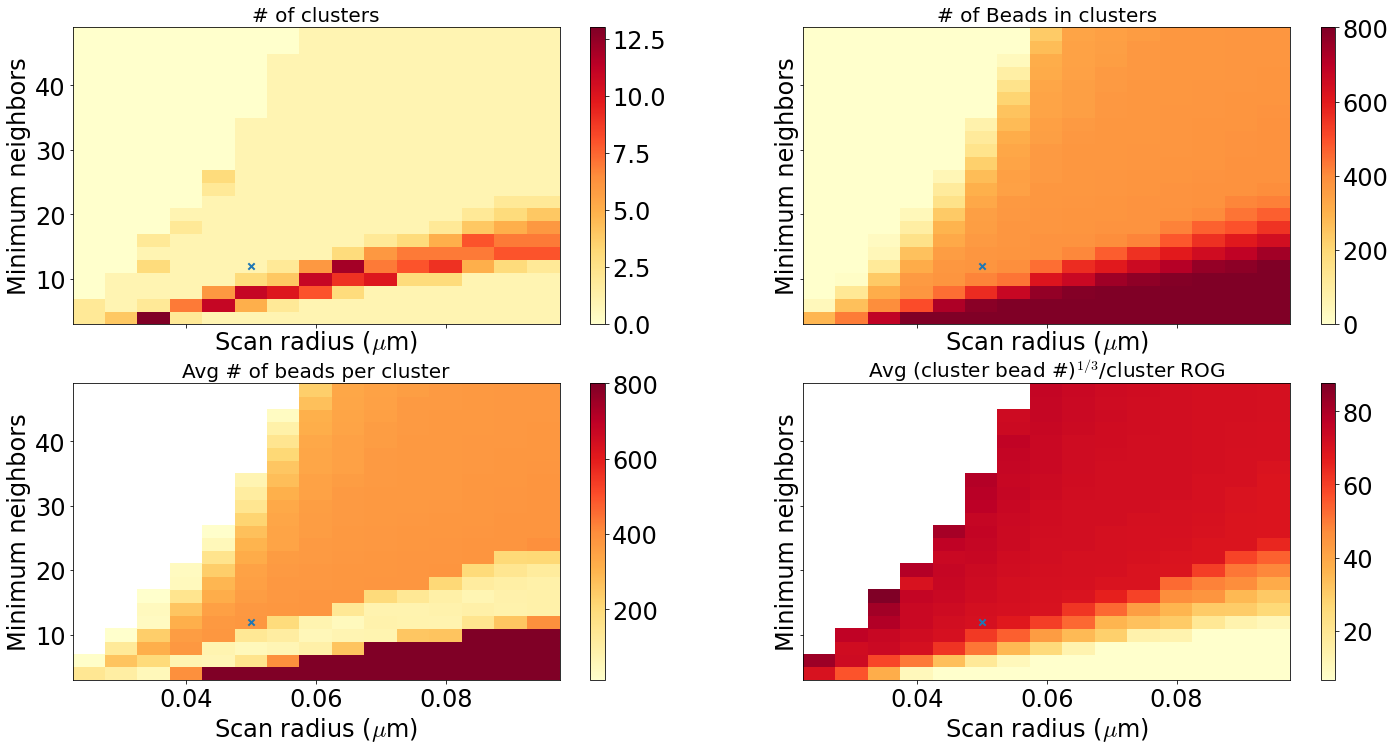

In [67]:
data_path = (
    ws_path / "22-04-28_aLchr1_scan.12_line800_sticky55nm_eps1_Ka30_5umconf/simulations/s6")
ss_ind = 1
end_ind = 500
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(2, 2, figsize=(24, 12), sharex=True, sharey=True)
axarr = axarr.flatten()

X, Y = np.meshgrid(eps-.0025, min_sample-1)
c0 = axarr[0].pcolor(X,Y, clust_num_mat.T)
c1 = axarr[1].pcolor(X,Y, beads_in_clust_mat.T)
c2 = axarr[2].pcolor(X,Y, avg_bead_per_clust_mat.T)
c3 = axarr[3].pcolor(X,Y, 1./(avg_rog_mat.T))
cbar0 = fig.colorbar(c0, ax=axarr[0])
cbar1 = fig.colorbar(c1, ax=axarr[1])
cbar2 = fig.colorbar(c2, ax=axarr[2])
cbar3 = fig.colorbar(c3, ax=axarr[3])
_ = axarr[0].set_title(f'# of clusters')
_ = axarr[1].set_title(f'# of Beads in clusters')
_ = axarr[2].set_title(f'Avg # of beads per cluster')
_ = axarr[3].set_title('Avg (cluster bead #)$^{1/3}$/cluster ROG')
for ax in axarr:
    _ = ax.scatter(.05, 12, s=40, marker='x')
    _ = ax.set_xlabel('Scan radius ($\mu$m)')
    _ = ax.set_ylabel('Minimum neighbors')
            



# Distance vs index

number of estimated clusters : 8
number of thresholded clusters : 2
Volume of condensate: 4138151.1045014383 nm$^3$
Volume per bead: 16421.234541672373 nm$^3$
Volume of condensate: 2711793.6878958805 nm$^3$
Volume per bead: 15407.918681226594 nm$^3$


/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


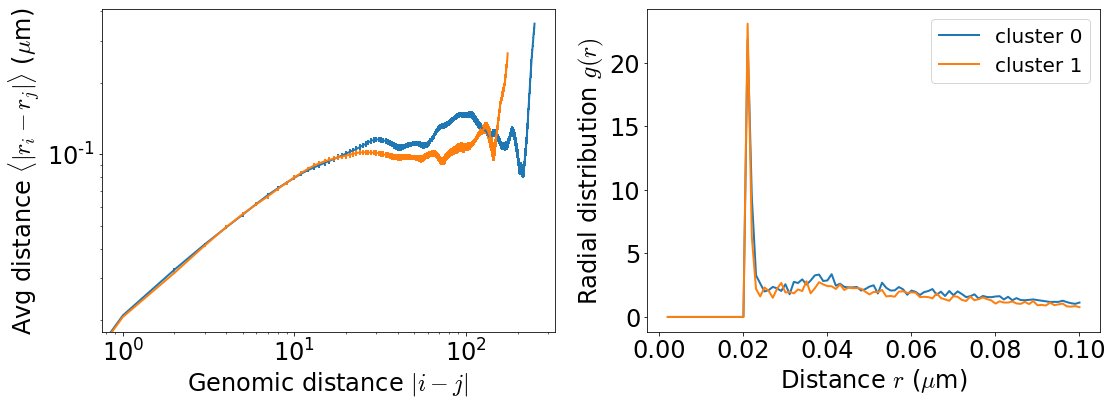

In [42]:
data_path = (
    ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
t = -1 # Snapshot time to use

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, t] + sy_dat[:, 5:8, t])

    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr)

    for i, cli in enumerate(cluster_label_inds):
        clust_ind_com = com_arr[cli]
        hull = ConvexHull(clust_ind_com)
        print(f"Volume of condensate: {1e9*hull.volume} nm$^3$")
        print(f"Volume per bead: {1e9*hull.volume/float(clust_ind_com.shape[0])} nm$^3$")

        avg_dist_arr, avg_dist_sem_arr = dist_vs_idx_dist(clust_ind_com) 
        dist_mat = np.linalg.norm((clust_ind_com[:, np.newaxis, :] -
                               clust_ind_com[np.newaxis, :, :]),
                              axis=2)
        # hist_max =1.1 * np.max(dist_mat)
        hist_max = .3
        rad_distr_func, rad_bin_edges = ca.rad_distr_func_at_t(dist_mat, nbins=int(hist_max/.001), hist_max=hist_max)
    
        _ = axarr[0].errorbar(np.arange(len(avg_dist_arr)), avg_dist_arr, yerr=avg_dist_sem_arr, label=f'cluster {i}')
        _ = axarr[1].plot(rad_bin_edges[2:], rad_distr_func[1:]*hull.volume, label=f'cluster {i}')


_ = axarr[0].set_yscale("log")
_ = axarr[0].set_xscale("log")
# _ = axarr[1].set_yscale("log")


_ = axarr[0].set_xlabel(r"Genomic distance $|i - j|$ ")
_ = axarr[0].set_ylabel(r"Avg distance $\langle |r_i - r_j|\rangle$ ($\mu$m)")
_ = axarr[1].set_xlabel(r"Distance $r$ ($\mu$m)")
_ = axarr[1].set_ylabel(r"Radial distribution $g(r)$")

# _ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr[1].legend()
fig.tight_layout()
# cgf.graph_clust_snapshot(axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/env

number of estimated clusters : 8
number of thresholded clusters : 4
Volume of condensate: 3023254.923903121 nm$^3$
Volume per bead: 13742.067835923279 nm$^3$
Volume of condensate: 227265.46519933955 nm$^3$
Volume per bead: 7575.515506644651 nm$^3$
Volume of condensate: 116325.73569777215 nm$^3$
Volume per bead: 5539.320747512959 nm$^3$
Volume of condensate: 2145888.738625435 nm$^3$
Volume per bead: 12622.874933090796 nm$^3$


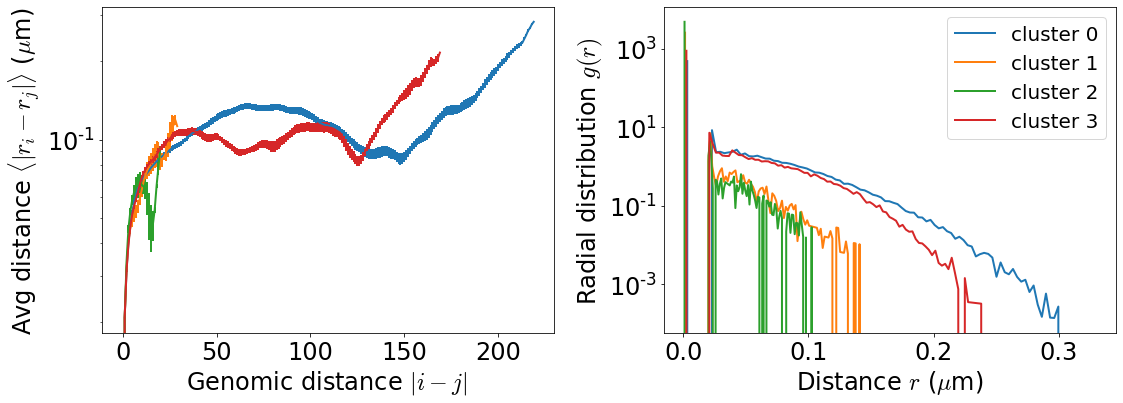

In [21]:
data_path = (
    ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
t = -1000 # Snapshot time to use

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, t] + sy_dat[:, 5:8, t])

    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr)

    for i, cli in enumerate(cluster_label_inds):
        clust_ind_com = com_arr[cli]
        hull = ConvexHull(clust_ind_com)
        print(f"Volume of condensate: {1e9*hull.volume} nm$^3$")
        print(f"Volume per bead: {1e9*hull.volume/float(clust_ind_com.shape[0])} nm$^3$")

        avg_dist_arr, avg_dist_sem_arr = dist_vs_idx_dist(clust_ind_com) 
        dist_mat = np.linalg.norm((clust_ind_com[:, np.newaxis, :] -
                               clust_ind_com[np.newaxis, :, :]),
                              axis=2)
        rad_distr_func, rad_bin_edges = ca.rad_distr_func_at_t(dist_mat, hist_max=1.1*np.max(dist_mat))
    
        _ = axarr[0].errorbar(np.arange(len(avg_dist_arr)), avg_dist_arr, yerr=avg_dist_sem_arr, label=f'cluster {i}')
        _ = axarr[1].plot(rad_bin_edges[1:], rad_distr_func[:]*hull.volume, label=f'cluster {i}')


_ = axarr[0].set_yscale("log")
_ = axarr[1].set_yscale("log")

_ = axarr[0].set_xlabel(r"Genomic distance $|i - j|$ ")
_ = axarr[0].set_ylabel(r"Avg distance $\langle |r_i - r_j|\rangle$ ($\mu$m)")
_ = axarr[1].set_xlabel(r"Distance $r$ ($\mu$m)")
_ = axarr[1].set_ylabel(r"Radial distribution $g(r)$")

# _ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr[1].legend()
fig.tight_layout()



    
    
    
    
    # cgf.graph_clust_snapshot(axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



/cm/shared/sw/nix/store/ma56jkd87lypmn6r2zscpz42qz4a5gic-py-numpy-1.20.3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/cm/shared/sw/nix/store/ma56jkd87lypmn6r2zscpz42qz4a5gic-py-numpy-1.20.3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/cm/shared/sw/nix/store/ma56jkd87lypmn6r2zscpz42qz4a5gic-py-numpy-1.20.3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/cm/shared/sw/nix/store/ma56jkd87lypmn6r2zscpz42qz4a5gic-py-numpy-1.20.3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/cm/shared/sw/nix/store/ma56jkd87lypmn6r2zscpz42qz4a5gic-py-numpy-1.20.3/lib

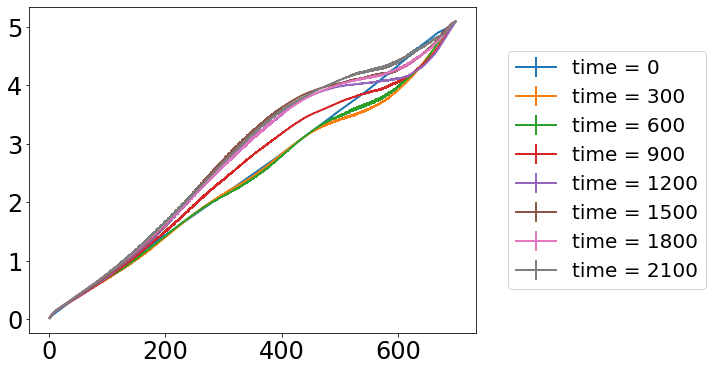

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
for time_ind in np.arange(0, com_arr.shape[-1], 300):
    sep_mat = np.linalg.norm(com_arr[:, np.newaxis, :, time_ind] - com_arr[np.newaxis, :, :, time_ind], axis=2)
    #print(sep_mat)
    avg_dist_arr = []
    avg_dist_sem_arr = []
    for i in range(1,sep_mat.shape[0]):
        diag = np.diagonal(sep_mat, i)
        avg_dist_arr += [diag.mean()]
        avg_dist_sem_arr += [stats.sem(diag)]
    
    _ = ax.errorbar(np.arange(1,len(avg_dist_arr)+1), avg_dist_arr, yerr=avg_dist_sem_arr, label=f'time = {time_ind}')

_ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))

  0%|          | 0/6 [00:00<?, ?it/s]

0.0


/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


82.66666666666667
165.33333333333334
248.0
330.6666666666667
413.33333333333337


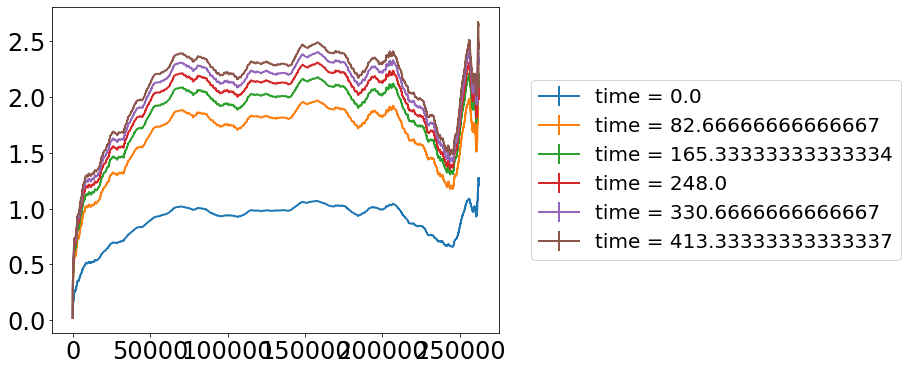

In [ ]:
data_path = (ceph_path / '22-07-06_aLc1_line262144_hilbert_confRad3um_256')
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, ax = plt.subplots(figsize=(8,6))
data_list = [] 
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    for time_ind in tqdm(np.arange(0, time_arr.size, time_arr.size/6)):
        print(time_ind)
        sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, time_ind]
        com_arr = .5 * (sy_dat[:, 2:5] + sy_dat[:, 5:8])
        avg_dist_arr = np.zeros(com_arr.shape[0]-1) 
        avg_dist_sem_arr = np.zeros(com_arr.shape[0]-1)
        for i in range(1, com_arr.shape[0]):
            dist_arr = np.linalg.norm(com_arr[i:] - com_arr[:-i], axis=-1)
            avg_dist_arr[i-1] = dist_arr.mean()
            avg_dist_sem_arr[i-1] = stats.sem(dist_arr)
            
        _ = ax.errorbar(np.arange(avg_dist_arr.size)+1, avg_dist_arr, yerr=avg_dist_sem_arr, label=f'time = {time_ind}')
        data_list += [{'avg_dist': avg_dist_arr,
                       'avg_dist_sem_arr': avg_dist_sem_arr,
                       'time': time_ind,
        }]
        

_ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))

## Single cluster characterization

/tmp/ipykernel_2784479/1479522363.py:36: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr[1].plot(cond_data[:,0], volume_arr/bead_arr, label = f'Condensate {ci}')


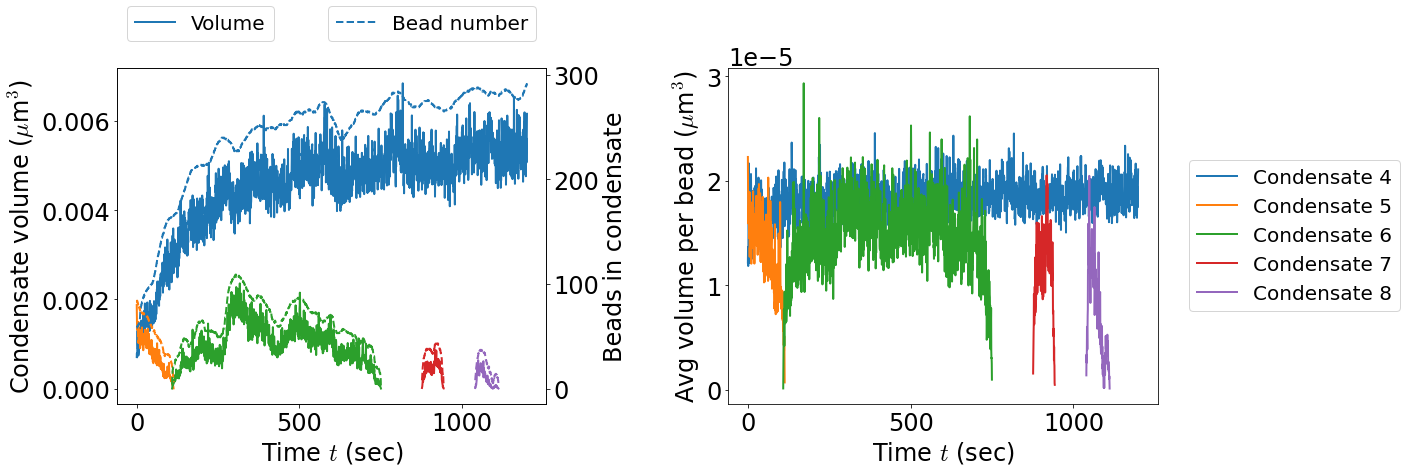

In [53]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-04-15_aLc1_scan.32_line800_sticky_5umconf_2cond100sep200/simulations/s5")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(1,2, figsize=(20, 7))
axarr0 = axarr[0].twinx()

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    for ci, cond_str in enumerate(h5_data['analysis/condensates']):
        cond_data = h5_data[f'analysis/condensates/{cond_str}']
        if cond_data.shape[0] < 100:
            continue
        # print(cond_data)
        volume_arr = np.zeros(cond_data.shape[0])
        bead_arr = np.zeros(cond_data.shape[0])
        for i, cdat in enumerate(cond_data):
            t = np.where(time_arr == cdat[0])[0][0]
            parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
            if parts.shape[0] < 3:
                continue
            hull = ConvexHull(parts)
            volume_arr[i] = hull.volume
            bead_arr[i] = parts.shape[0]
        
        _ = axarr[0].plot(cond_data[:,0], volume_arr)
        _ = axarr0.plot(cond_data[:,0], bead_arr,  linestyle='--')
        _ = axarr[1].plot(cond_data[:,0], volume_arr/bead_arr, label = f'Condensate {ci}')

_ = axarr[0].legend(['Volume'], loc='lower left', bbox_to_anchor=(0., 1.05))
_ = axarr0.legend(['Bead number'], loc='lower right', bbox_to_anchor=(1., 1.05))
_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ (sec)')
_ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
_ = axarr0.set_ylabel('Beads in condensate')
_ = axarr[1].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout() 
    
        

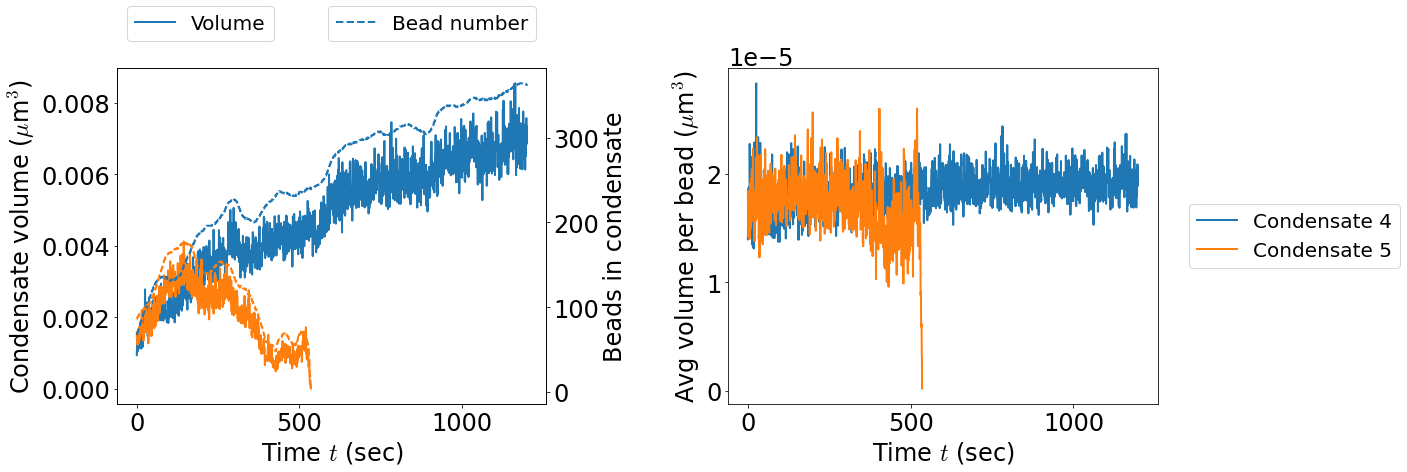

In [54]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-04-15_aLc1_scan.32_line800_sticky_5umconf_2cond100sep200/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(1,2, figsize=(20, 7))
axarr0 = axarr[0].twinx()

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    for ci, cond_str in enumerate(h5_data['analysis/condensates']):
        cond_data = h5_data[f'analysis/condensates/{cond_str}']
        if cond_data.shape[0] < 100:
            continue
        # print(cond_data)
        volume_arr = np.zeros(cond_data.shape[0])
        bead_arr = np.zeros(cond_data.shape[0])
        for i, cdat in enumerate(cond_data):
            t = np.where(time_arr == cdat[0])[0][0]
            parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
            if parts.shape[0] < 3:
                continue
            hull = ConvexHull(parts)
            volume_arr[i] = hull.volume
            bead_arr[i] = parts.shape[0]
        
        _ = axarr[0].plot(cond_data[:,0], volume_arr)
        _ = axarr0.plot(cond_data[:,0], bead_arr,  linestyle='--')
        _ = axarr[1].plot(cond_data[:,0], volume_arr/bead_arr, label = f'Condensate {ci}')

_ = axarr[0].legend(['Volume'], loc='lower left', bbox_to_anchor=(0., 1.05))
_ = axarr0.legend(['Bead number'], loc='lower right', bbox_to_anchor=(1., 1.05))
_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ (sec)')
_ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
_ = axarr0.set_ylabel('Beads in condensate')
_ = axarr[1].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout() 
    
        

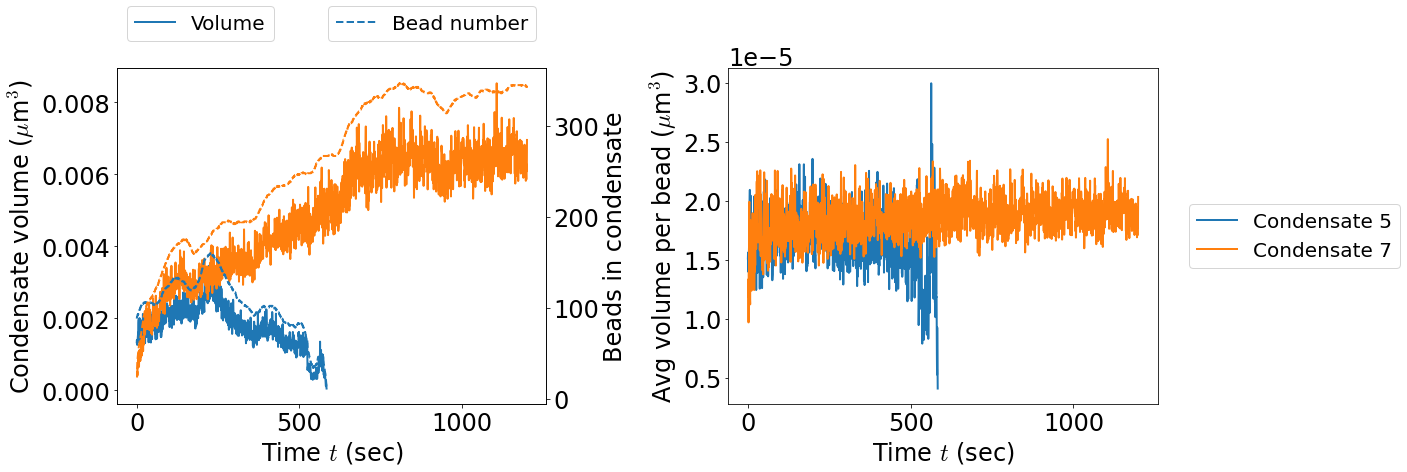

In [55]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-04-15_aLc1_scan.32_line800_sticky_5umconf_2cond100sep200/simulations/s20")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(1,2, figsize=(20, 7))
axarr0 = axarr[0].twinx()

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    for ci, cond_str in enumerate(h5_data['analysis/condensates']):
        cond_data = h5_data[f'analysis/condensates/{cond_str}']
        if cond_data.shape[0] < 100:
            continue
        # print(cond_data)
        volume_arr = np.zeros(cond_data.shape[0])
        bead_arr = np.zeros(cond_data.shape[0])
        for i, cdat in enumerate(cond_data):
            t = np.where(time_arr == cdat[0])[0][0]
            parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
            if parts.shape[0] < 3:
                continue
            hull = ConvexHull(parts)
            volume_arr[i] = hull.volume
            bead_arr[i] = parts.shape[0]
        
        _ = axarr[0].plot(cond_data[:,0], volume_arr)
        _ = axarr0.plot(cond_data[:,0], bead_arr,  linestyle='--')
        _ = axarr[1].plot(cond_data[:,0], volume_arr/bead_arr, label = f'Condensate {ci}')

_ = axarr[0].legend(['Volume'], loc='lower left', bbox_to_anchor=(0., 1.05))
_ = axarr0.legend(['Bead number'], loc='lower right', bbox_to_anchor=(1., 1.05))
_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ (sec)')
_ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
_ = axarr0.set_ylabel('Beads in condensate')
_ = axarr[1].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout() 
    
        

/tmp/ipykernel_2784479/3303371598.py:41: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr[1].plot(cond_time, volume_arr/bead_arr, label = f'Seed: {sd_num(h5_data)}')
/tmp/ipykernel_2784479/3303371598.py:42: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr[1].hlines((volume_arr/bead_arr).mean(), time_arr[0], time_arr[-1])
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/tmp/ipykernel_2784479/3303371598.py:41: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr[1].plot(cond_time, volume_arr/bead_arr, label = f'Seed: {sd_num(h5_data)}')
/tmp/ipykernel_2784479/3303371598.py:42: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr[1].hlines((volume_arr/bead_arr).mean(), time_arr[0], time_arr[-1])
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_a

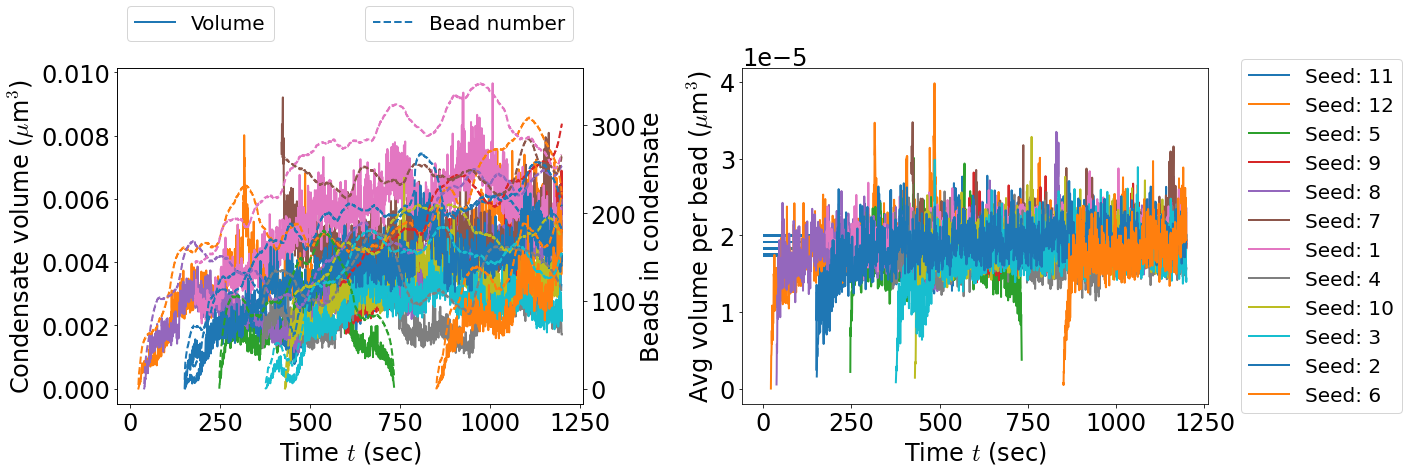

In [63]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-04-15_aLchr1_scan7.12_line800_stickyL.01-.07_eps1_Ke30_5umconf/simulations/Ls0.04")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(1,2, figsize=(20, 7))
axarr0 = axarr[0].twinx()

for h5_file in data_path.glob('*/analysis/*.h5'):
    with h5py.File(h5_file, 'r+') as h5_data:
        time_arr = h5_data['time'][ss_ind:end_ind]
        analysis_grp = h5_data['analysis']

        sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                            :, ss_ind:end_ind]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        largest_cond = 0
        for ci, cond_str in enumerate(h5_data['analysis/condensates']):
            cond_data = h5_data[f'analysis/condensates/{cond_str}']
            max_cond_size = np.max(cond_data[:,2] -cond_data[:, 1])
            if max_cond_size < largest_cond:
                continue
            largest_cond = max_cond_size
            cond_time = cond_data[:,0]
            # print(cond_data)
            volume_arr = np.zeros(cond_data.shape[0])
            bead_arr = np.zeros(cond_data.shape[0])
            for i, cdat in enumerate(cond_data):
                t = np.where(time_arr == cdat[0])[0][0]
                parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
                if parts.shape[0] < 4:
                    continue
                hull = ConvexHull(parts)
                volume_arr[i] = hull.volume
                bead_arr[i] = parts.shape[0]
            
        _ = axarr[0].plot(cond_time, volume_arr)
        _ = axarr0.plot(cond_time, bead_arr,  linestyle='--')
        _ = axarr[1].plot(cond_time, volume_arr/bead_arr, label = f'Seed: {sd_num(h5_data)}')
        _ = axarr[1].hlines((volume_arr/bead_arr).mean(), time_arr[0], time_arr[-1])

    _ = axarr[0].legend(['Volume'], loc='lower left', bbox_to_anchor=(0., 1.05))
    _ = axarr0.legend(['Bead number'], loc='lower right', bbox_to_anchor=(1., 1.05))
    _ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    for ax in axarr:
        _ = ax.set_xlabel('Time $t$ (sec)')
    _ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
    _ = axarr0.set_ylabel('Beads in condensate')
    _ = axarr[1].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout() 
    
        

In [ ]:
data_path = (ceph_path / "22_aLc800_sticky_runs/22-04-15_aLchr1_scan7.12_line800_stickyL.01-.07_eps1_Ke30_5umconf/simulations")
param_list = [0.04, 0.05, 0.06, 0.07]
# param_list = ["0.04", "0.05", "0.06", "0.07"]
param_paths = [data_path / f"Ls{p}" for p in param_list]
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

volume_seed_avg_arr = []
num_bead_seed_avg_arr = []
bead_vol_seed_avg_arr = []
for ppaths in param_paths:
    volume_mean_arr = []
    num_bead_mean_arr = []
    bead_vol_mean_arr = []
    for h5_file in ppaths.glob('*/analysis/*.h5'):
        with h5py.File(h5_file, 'r+') as h5_data:
            time_arr = h5_data['time'][ss_ind:end_ind]
            analysis_grp = h5_data['analysis']
            
            try:
                sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            except:
                print(f"No sylinder data in {sd_num(h5_data)}.")
                continue
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            largest_cond = 0
            for ci, cond_str in enumerate(h5_data['analysis/condensates']):
                cond_data = h5_data[f'analysis/condensates/{cond_str}']
                max_cond_size = np.max(cond_data[:,2] -cond_data[:, 1])
                if max_cond_size < largest_cond:
                    continue
                largest_cond = max_cond_size
                cond_time = cond_data[:,0]
                # print(cond_data)
                volume_arr = np.zeros(cond_data.shape[0])
                bead_arr = np.zeros(cond_data.shape[0])
                for i, cdat in enumerate(cond_data):
                    t = np.where(time_arr == cdat[0])[0][0]
                    parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
                    if parts.shape[0] < 4:
                        continue
                    hull = ConvexHull(parts)
                    volume_arr[i] = hull.volume
                    bead_arr[i] = parts.shape[0]
            volume_mean_arr += [volume_arr.mean()]
            num_bead_mean_arr += [bead_arr.mean()]
            bead_vol_mean_arr += [(volume_arr/bead_arr).mean()]
                
    volume_seed_avg_arr += [volume_mean_arr]
    num_bead_seed_avg_arr += [num_bead_mean_arr]
    bead_vol_seed_avg_arr += [bead_vol_mean_arr]
                
            # _ = axarr[0].plot(cond_time, volume_arr)
            # _ = axarr0.plot(cond_time, bead_arr,  linestyle='--')
            # _ = axarr[1].plot(cond_time, volume_arr/bead_arr, label = f'Seed: {sd_num(h5_data)}')
            # _ = axarr[1].hlines((volume_arr/bead_arr).mean(), time_arr[0], time_arr[-1])
fig, axarr = plt.subplots(1,3, figsize=(25, 6))
#print(volume_seed_avg_arr)
#print(np.ma.masked_invalid(np.array(bead_vol_seed_avg_arr)))
_ = axarr[0].violinplot(volume_seed_avg_arr)
_ = axarr[1].violinplot(num_bead_seed_avg_arr)
bvsaa = [ np.array(a)[~np.isnan(a)] for a in bead_vol_seed_avg_arr]

_ = axarr[2].violinplot(bvsaa)
        # _ = axarr[0].legend(['Volume'], loc='lower left', bbox_to_anchor=(0., 1.05))
        # _ = axarr0.legend(['Bead number'], loc='lower right', bbox_to_anchor=(1., 1.05))
        # _ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
        # for ax in axarr:
        #     _ = ax.set_xlabel('Time $t$ (sec)')
        # _ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
        # _ = axarr0.set_ylabel('Beads in condensate')
        # _ = axarr[1].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout() 
    
        

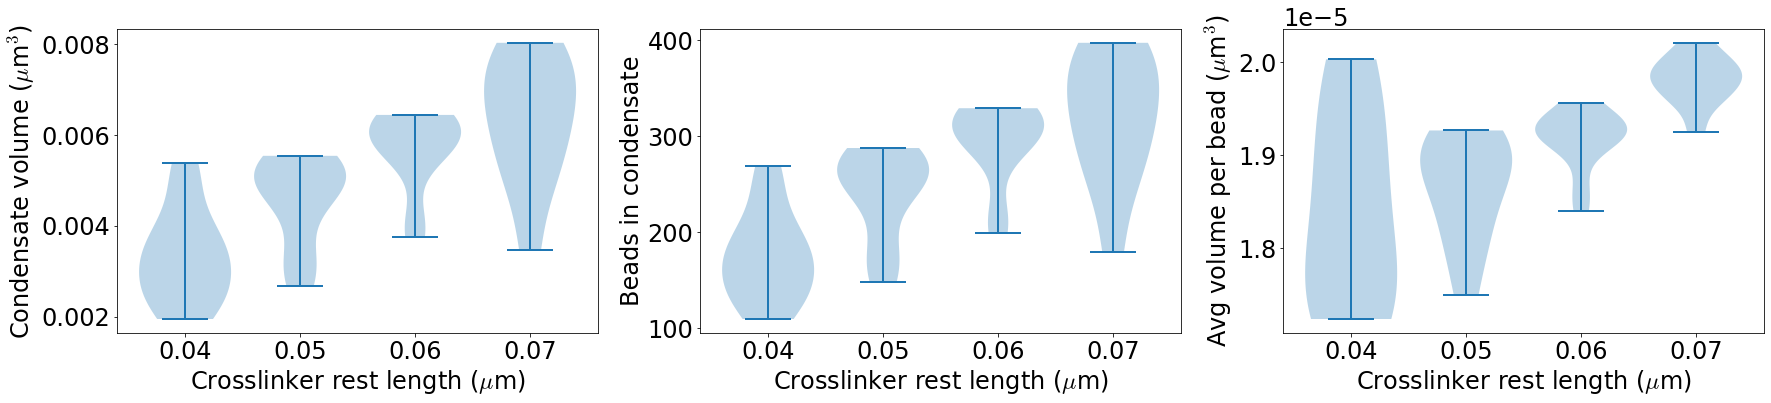

In [97]:
fig, axarr = plt.subplots(1,3, figsize=(25, 6))
#print(volume_seed_avg_arr)
#print(np.ma.masked_invalid(np.array(bead_vol_seed_avg_arr)))
_ = axarr[0].violinplot(volume_seed_avg_arr, positions=param_list, widths=.8*(param_list[1]-param_list[0]))
_ = axarr[1].violinplot(num_bead_seed_avg_arr, positions=param_list,widths=.8*(param_list[1]-param_list[0]))
bvsaa = [ np.array(a)[~np.isnan(a)] for a in bead_vol_seed_avg_arr]

_ = axarr[2].violinplot(bvsaa, positions=param_list,widths=.8*(param_list[1]-param_list[0]))
for ax in axarr:
    _ = ax.set_xlabel('Crosslinker rest length ($\mu$m)')
_ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
_ = axarr[1].set_ylabel('Beads in condensate')
_ = axarr[2].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout()

# Large simulations

## Free polymer

In [4]:
data_path = (ws_path / "22-07-12_aLc1_line16000_sticky_100um")

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

# Get bead position information
with h5py.File(next(data_path.glob('analysis/22*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

# Get cluster information
h5_clust_file = (data_path / 'analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]



(2401,)


number of estimated clusters : 50
number of thresholded clusters : 27


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


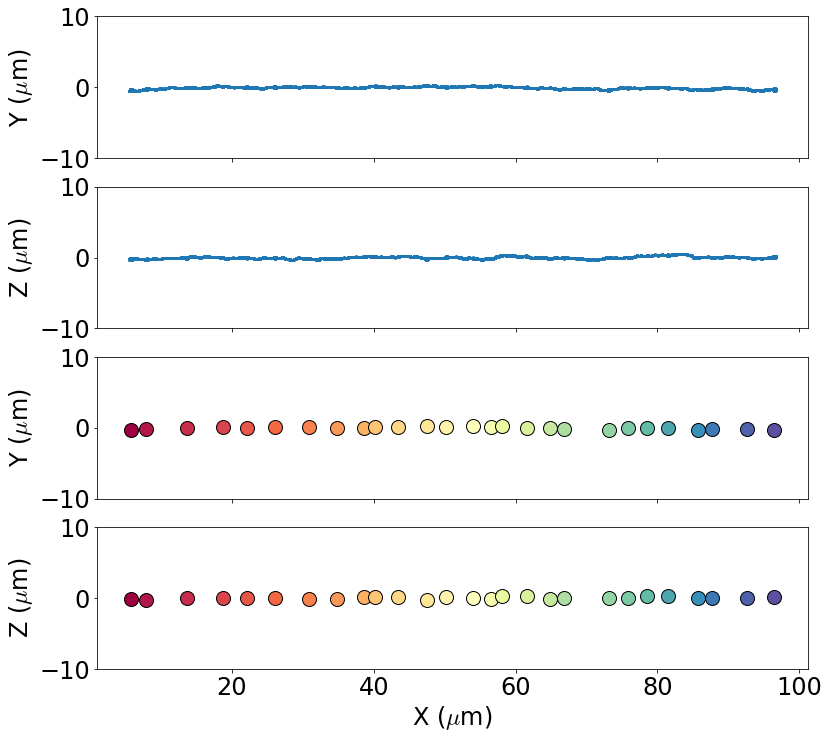

In [5]:
clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
    com_arr[:, :, -1])

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
_ = cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)

for ax in axarr:
    _ = ax.set_ylim(-10,10)

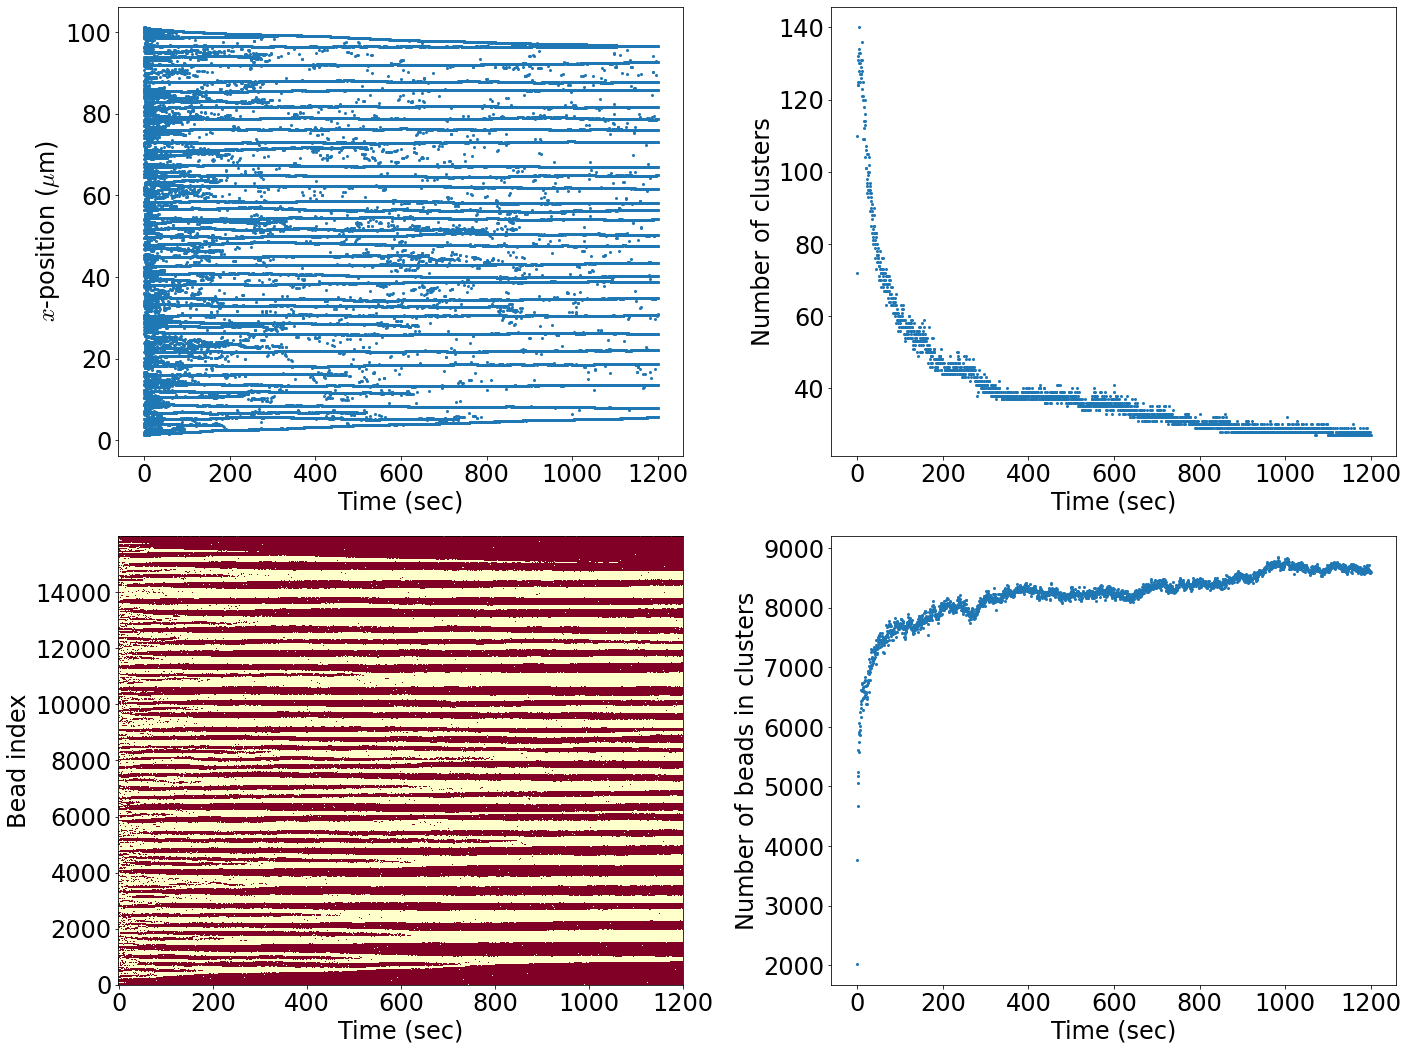

In [6]:
flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []
num_clusters_list = []
num_cluster_beads_list = []

for c, clust_grp in enumerate(clusters):
    #TODO Could put a thresholding function here
    num_clusters_list += [len(clust_grp)]
    num_beads = 0
    for i, clust in enumerate(clust_grp):
        flat_time_arr += [clust.time]
        flat_clust_cent_arr += [clust.center]
        flat_clust_ind_arr += [clust.part_ids]
        num_beads += len(clust.part_ids)

    num_cluster_beads_list += [num_beads]
    
bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_grp in enumerate(clusters):
    for clust in clust_grp:
        bead_ind_arr[clust.part_ids,c] += one_mask[clust.part_ids]
# bead_ind_arr[:,:-1] += bead_ind_arr[:,1:]
# bead_ind_arr *= .5


fig, axarr = plt.subplots(2,2, figsize=(20, 15))
X, Y = np.meshgrid(time_arr, np.arange(com_arr.shape[0]))
c = axarr[1,0].pcolor(X, Y, bead_ind_arr, shading='nearest')

flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
_ = axarr[0,0].scatter(flat_time_arr, flat_clust_cent_arr[:,0])
_ = axarr[0,1].scatter(time_arr[:-1], num_clusters_list)
_ = axarr[1,1].scatter(time_arr[:-1], num_cluster_beads_list)
_ = axarr[0,0].set_ylabel('$x$-position ($\mu$m)')
_ = axarr[0,1].set_ylabel('Number of clusters')
_ = axarr[1,0].set_ylabel('Bead index')
_ = axarr[1,1].set_ylabel('Number of beads in clusters')
for ax in axarr.flatten():
    _ = ax.set_xlabel('Time (sec)')
fig.tight_layout()

2400


/tmp/ipykernel_2998629/2863863724.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axarr.pcolor(T,X, hists.T)


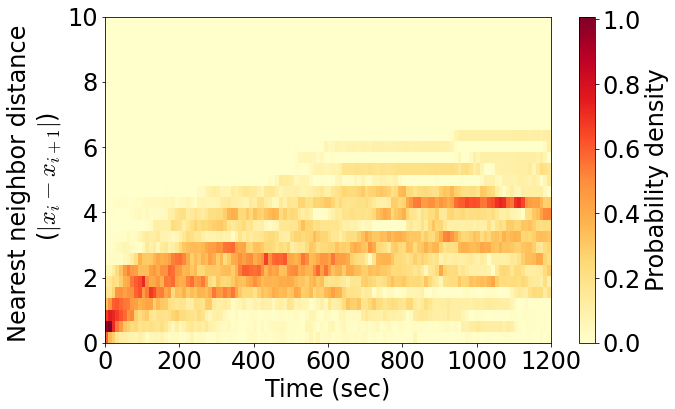

In [7]:
fig, axarr = plt.subplots(1,1, figsize=(10, 6))

N = 20 # Number of time snapshots in grouping
sep_arr_list = []
print(len(clusters))
for i in range(0, len(clusters), N):
    # Step through time grouped clusters and collect centers
    cluster_centers = []
    for j in range(N):
        # Sort the clusters by the x-distance so you know that each cluster
        # is in order by nearest neighbors
        time_grp = sorted(clusters[i+j], key=lambda x: x.center[0])
        cluster_centers += [c.center for c in time_grp] 
    cluster_centers = np.array(cluster_centers)
    # Distance between cluster centers of nearest neighbors 
    
    sep_arr = cluster_centers[1:, 0] - cluster_centers[:-1, 0] 
    sep_arr_list += [sep_arr]

max_dist = 10
nbins = 30
hists = np.zeros((len(sep_arr_list), nbins)) 
for i, seps in enumerate(sep_arr_list):
    hists[i], bin = np.histogram(seps, bins=nbins, range=(0, max_dist),density=True)

T,X = np.meshgrid(time_arr[::N], np.linspace(0, max_dist, nbins))
c = axarr.pcolor(T,X, hists.T)
cbar = fig.colorbar(c, ax=axarr, label='Probability density')
    

_ = axarr.set_ylabel("Nearest neighbor distance \n ($|x_i - x_{i+1}|$)") 
_ = axarr.set_xlabel("Time (sec)")

/tmp/ipykernel_2998629/2584167721.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c0 = axarr[0].pcolor(T,X, hists.T)
/tmp/ipykernel_2998629/2584167721.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c1 = axarr[1].pcolor(T,X, dens_hists.T)


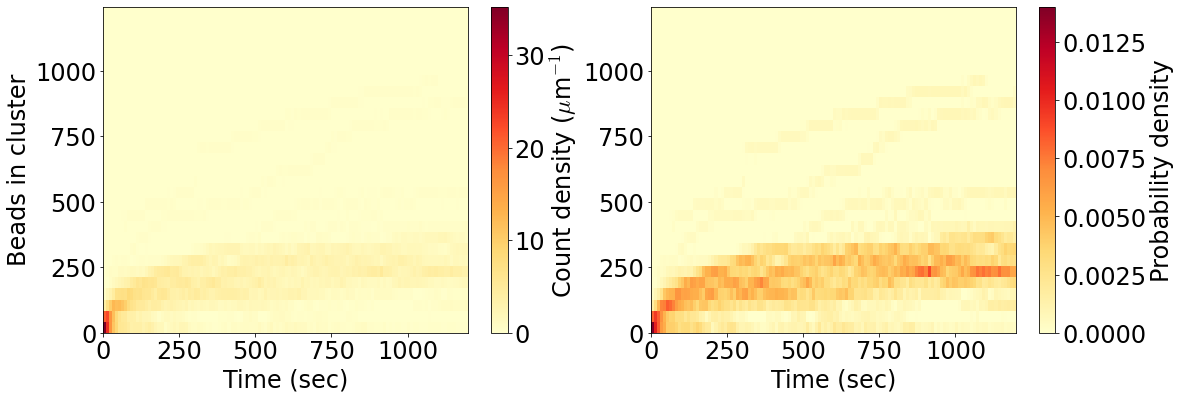

In [8]:
fig, axarr = plt.subplots(1,2, figsize=(18, 6))

N = 20 # Number of time snapshots in grouping
cluster_size_list = []
for i in range(0, len(clusters), N):
    # Step through time grouped clusters and collect centers
    cluster_sizes = []
    for j in range(N):
        # Sort the clusters by the x-distance so you know that each cluster
        # is in order by nearest neighbors
        cluster_sizes += [len(c.part_ids) for c in clusters[i+j]] 
    # Distance between cluster centers of nearest neighbors 
    
    cluster_size_list += [cluster_sizes]


max_size = max([max(cs) for cs in cluster_size_list])
nbins = 30
hists = np.zeros((len(cluster_size_list), nbins)) 
dens_hists = np.zeros((len(cluster_size_list), nbins)) 
for i, cs in enumerate(cluster_size_list):
    hists[i], bin = np.histogram(cs, bins=nbins, range=(0, max_size),density=True)
    hists[i] *= len(cs)
    dens_hists[i], bin = np.histogram(cs, bins=nbins, range=(0, max_size),density=True)

T,X = np.meshgrid(time_arr[::N], np.linspace(0, max_size, nbins))
c0 = axarr[0].pcolor(T,X, hists.T)
c1 = axarr[1].pcolor(T,X, dens_hists.T)
cbar0 = fig.colorbar(c0, ax=axarr[0], label='Count density ($\mu$m$^{-1}$)')
cbar1 = fig.colorbar(c1, ax=axarr[1], label='Probability density')

_ = axarr[0].set_ylabel("Beads in cluster") 
_ = axarr[0].set_xlabel("Time (sec)")
_ = axarr[1].set_xlabel("Time (sec)")

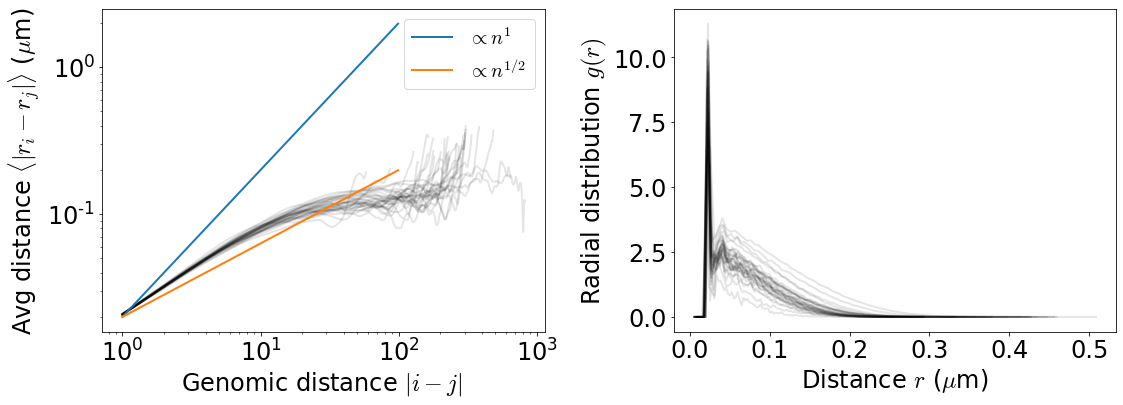

In [20]:

ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
t = -1000 # Snapshot time to use
fig, axarr = plt.subplots(1,2, figsize=(16, 6))


for i, clust in enumerate(clusters[t]):
    cli = clust.part_ids
    # if len(cli) < 100 or len(cli) > 250:
    if len(cli) < 50:
        continue
    clust_ind_com = com_arr[cli,:,t]
    # print(clust_ind_com )
    hull = ConvexHull(clust_ind_com)
    # print(f"Volume of condensate: {1e9*hull.volume} nm$^3$")
    # print(f"Volume per bead: {1e9*hull.volume/float(clust_ind_com.shape[0])} nm$^3$")

    warnings.filterwarnings('ignore')
    avg_dist_arr, avg_dist_sem_arr = dist_vs_idx_dist(clust_ind_com) 
    # print(avg_dist_arr)
    dist_mat = np.linalg.norm((clust_ind_com[:, np.newaxis, :] -
                            clust_ind_com[np.newaxis, :, :]),
                            axis=2)
    rad_distr_func, rad_bin_edges = ca.rad_distr_func_at_t(dist_mat, hist_max=1.1*np.max(dist_mat))

    # _ = axarr[0].errorbar(np.arange(len(avg_dist_arr)), avg_dist_arr, yerr=avg_dist_sem_arr, label=f'cluster {i}')
    _ = axarr[0].plot(np.arange(1,len(avg_dist_arr)), avg_dist_arr[1:], c='k', alpha=.1)
    _ = axarr[1].plot(rad_bin_edges[2:], rad_distr_func[1:]*hull.volume,  c='k', alpha=.1)

_ = axarr[0].plot(np.arange(1,100), .02*np.arange(1,100), label=r"$\propto n^{1}$")
_ = axarr[0].plot(np.arange(1,100), .02*np.sqrt(np.arange(1,100)), label=r"$ \propto n^{1/2}$")

_ = axarr[0].set_yscale("log")
_ = axarr[0].set_xscale("log")
# _ = axarr[1].set_yscale("log")
# _ = axarr[1].axvline(.02, color='r')
# _ = axarr[1].axvline(.05, color='r')


_ = axarr[0].set_xlabel(r"Genomic distance $|i - j|$ ")
_ = axarr[0].set_ylabel(r"Avg distance $\langle |r_i - r_j|\rangle$ ($\mu$m)")
_ = axarr[1].set_xlabel(r"Distance $r$ ($\mu$m)")
_ = axarr[1].set_ylabel(r"Radial distribution $g(r)$")

# _ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr[0].legend()
fig.tight_layout()

In [ ]:
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=20)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

451936


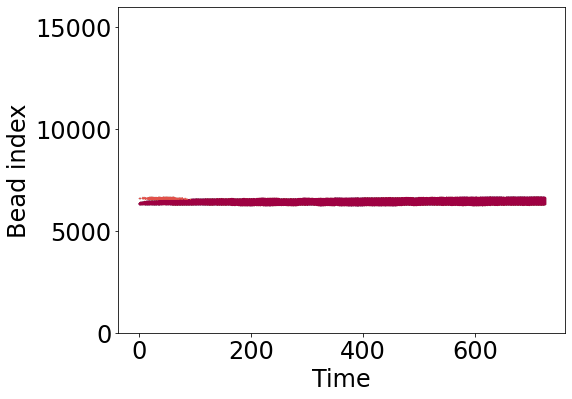

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,16000)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
print(biggest_tree.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(branch_roots))]
for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    if len(branch_clusters) < 20:
        continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [ ]:
# This could take a long time to run. There is a probably a way to do this faster
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
colors = [plt.cm.Spectral(tree) for tree in np.linspace(0, 1, len(trees))]
for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

## Pinned filament condensate analysis

In [24]:
data_path = (ceph_path /"22-07-15_aLc1_line16000_100umconf")

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

# Get bead position information
with h5py.File(next(data_path.glob('analysis/22*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

# Get cluster information
h5_clust_file = (data_path / 'analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]



(1450,)


number of estimated clusters : 50
number of thresholded clusters : 27


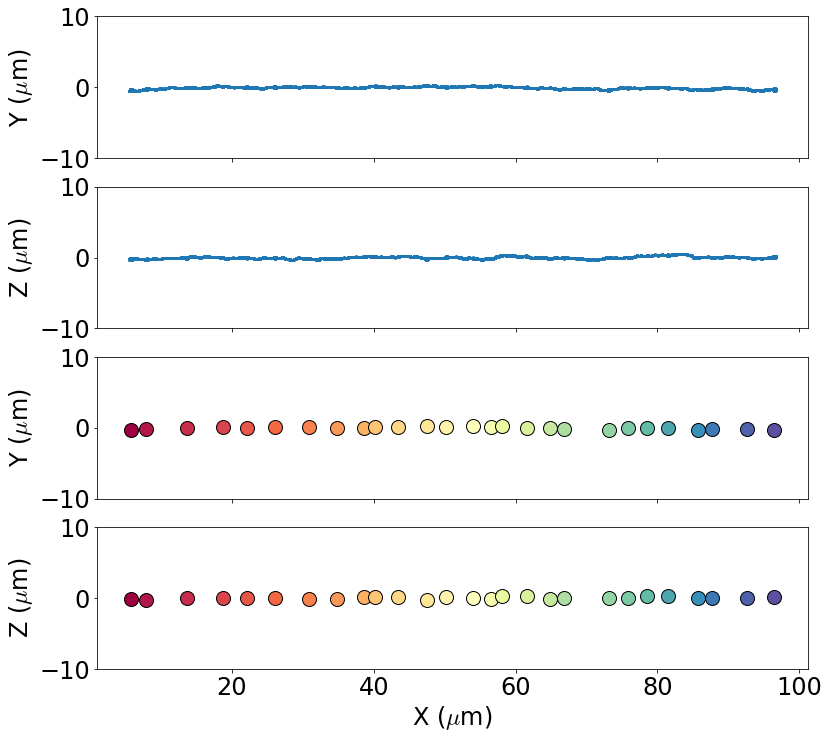

In [22]:
clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
    com_arr[:, :, -1])

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
_ = cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)

for ax in axarr:
    _ = ax.set_ylim(-10,10)

/tmp/ipykernel_1029582/2348051683.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axarr[1,0].pcolor(X, Y, bead_ind_arr)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


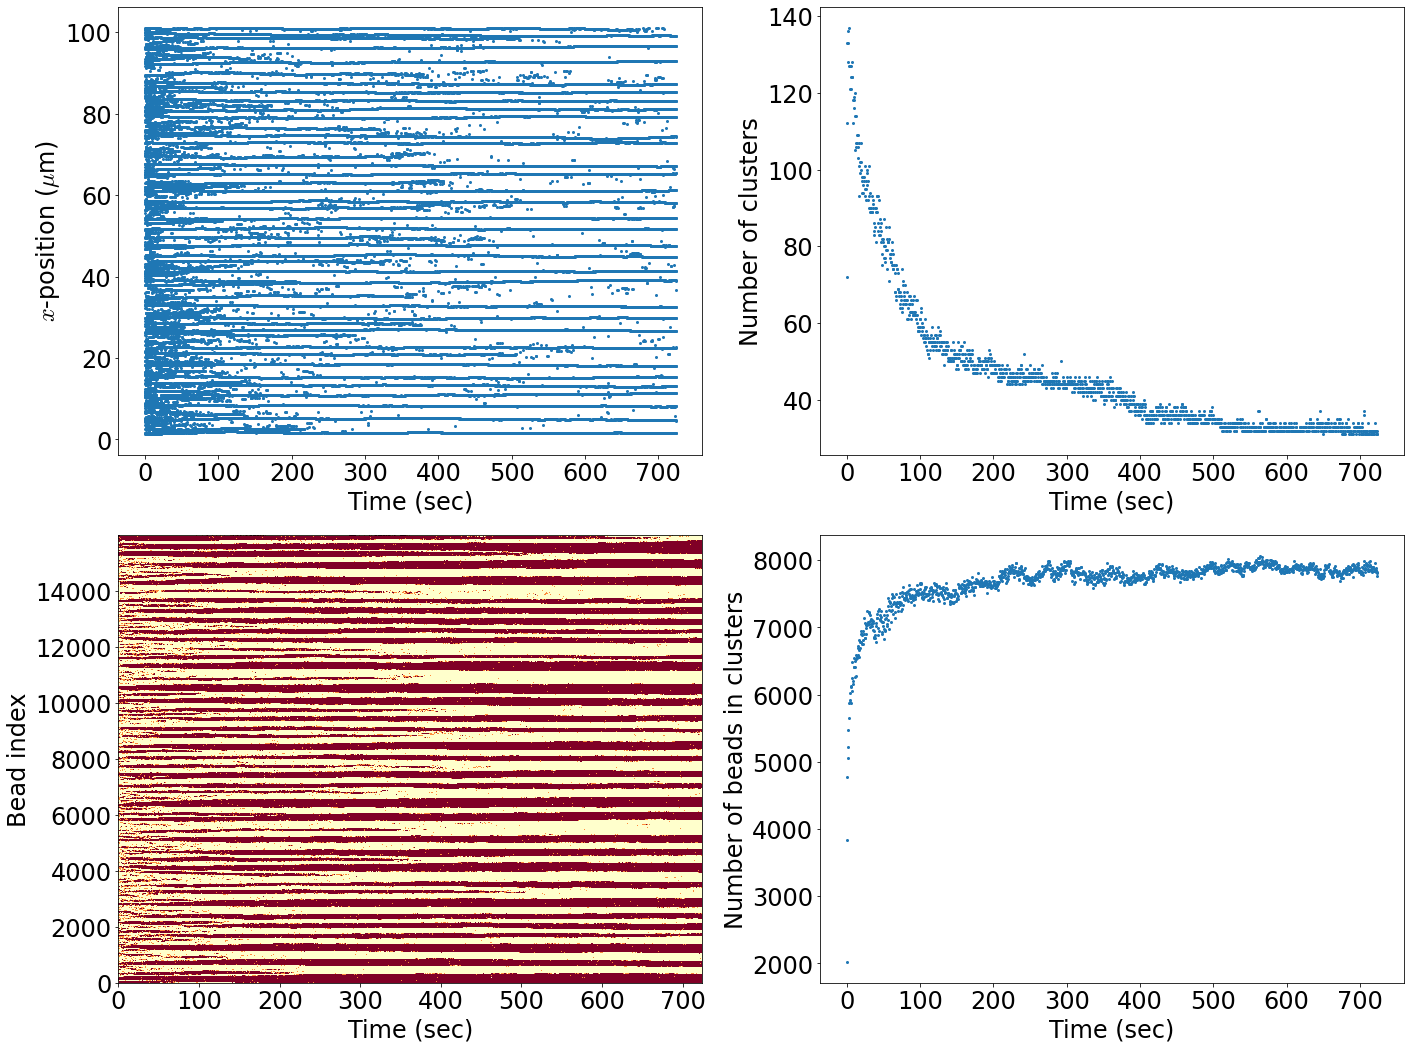

In [6]:
flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []
num_clusters_list = []
num_cluster_beads_list = []

for c, clust_grp in enumerate(clusters):
    num_clusters_list += [len(clust_grp)]
    num_beads = 0
    for i, clust in enumerate(clust_grp):
        flat_time_arr += [clust.time]
        flat_clust_cent_arr += [clust.center]
        flat_clust_ind_arr += [clust.part_ids]
        num_beads += len(clust.part_ids)

    num_cluster_beads_list += [num_beads]
    
bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_grp in enumerate(clusters):
    for clust in clust_grp:
        bead_ind_arr[clust.part_ids,c] += one_mask[clust.part_ids]
bead_ind_arr[:,:-1] += bead_ind_arr[:,1:]
bead_ind_arr *= .5


fig, axarr = plt.subplots(2,2, figsize=(20, 15))
X, Y = np.meshgrid(time_arr, np.arange(com_arr.shape[0]))
c = axarr[1,0].pcolor(X, Y, bead_ind_arr)

flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
_ = axarr[0,0].scatter(flat_time_arr, flat_clust_cent_arr[:,0])
_ = axarr[0,1].scatter(time_arr[:-1], num_clusters_list)
#axarr[1,0].scatter(flat_time_arr, flat_clust_ind_arr)
_ = axarr[1,1].scatter(time_arr[:-1], num_cluster_beads_list)
_ = axarr[0,0].set_ylabel('$x$-position ($\mu$m)')
_ = axarr[0,1].set_ylabel('Number of clusters')
_ = axarr[1,0].set_ylabel('Bead index')
_ = axarr[1,1].set_ylabel('Number of beads in clusters')
for ax in axarr.flatten():
    _ = ax.set_xlabel('Time (sec)')
fig.tight_layout()

1449


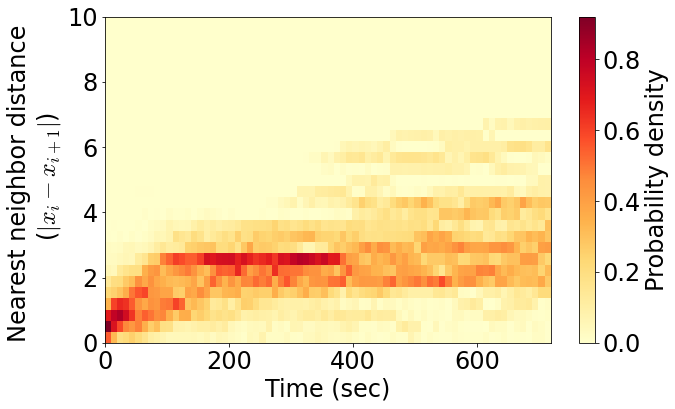

In [25]:
fig, axarr = plt.subplots(1,1, figsize=(10, 6))

N = 20 
sep_arr_list = []
print(len(clusters))
for i in range(0, len(clusters)-N, N):
    cluster_centers = []
    for j in range(N):
        time_grp = sorted(clusters[i+j], key=lambda x: x.center[0])
        cluster_centers += [c.center for c in time_grp] 
    cluster_centers = np.array(cluster_centers)
    sep_arr = cluster_centers[1:, 0] - cluster_centers[:-1, 0] 
    sep_arr_list += [sep_arr]
    # sep_arr = np.concatenate((sep_arr, np.abs(np.diagonal(sep_mat,1))))

max_dist = 10
nbins = 30
hists = np.zeros((len(sep_arr_list), nbins)) 
for i, seps in enumerate(sep_arr_list):
    hists[i], bin = np.histogram(seps, bins=nbins, range=(0, max_dist),density=True)

T,X = np.meshgrid(time_arr[::N], np.linspace(0, max_dist, nbins))
c = axarr.pcolor(T,X, hists.T)
cbar = fig.colorbar(c, ax=axarr, label='Probability density')
    

_ = axarr.set_ylabel("Nearest neighbor distance \n ($|x_i - x_{i+1}|$)") 
_ = axarr.set_xlabel("Time (sec)")

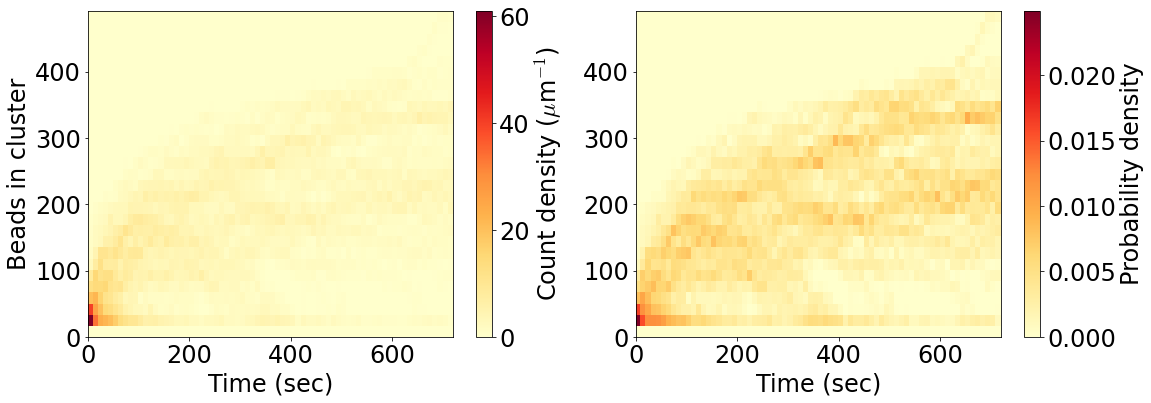

In [27]:
fig, axarr = plt.subplots(1,2, figsize=(18, 6))

N = 20 # Number of time snapshots in grouping
cluster_size_list = []
for i in range(0, len(clusters), N):
    # Step through time grouped clusters and collect centers
    cluster_sizes = []
    for j in range(N):
        if i+j >= len(clusters):
            break
        # Sort the clusters by the x-distance so you know that each cluster
        # is in order by nearest neighbors
        cluster_sizes += [len(c.part_ids) for c in clusters[i+j]] 
    # Distance between cluster centers of nearest neighbors 
    
    cluster_size_list += [cluster_sizes]


max_size = max([max(cs) for cs in cluster_size_list])
nbins = 30
hists = np.zeros((len(cluster_size_list), nbins)) 
dens_hists = np.zeros((len(cluster_size_list), nbins)) 
for i, cs in enumerate(cluster_size_list):
    hists[i], bin = np.histogram(cs, bins=nbins, range=(0, max_size),density=True)
    hists[i] *= len(cs)
    dens_hists[i], bin = np.histogram(cs, bins=nbins, range=(0, max_size),density=True)

T,X = np.meshgrid(time_arr[::N], np.linspace(0, max_size, nbins))
c0 = axarr[0].pcolor(T,X, hists.T)
c1 = axarr[1].pcolor(T,X, dens_hists.T)
cbar0 = fig.colorbar(c0, ax=axarr[0], label='Count density ($\mu$m$^{-1}$)')
cbar1 = fig.colorbar(c1, ax=axarr[1], label='Probability density')

_ = axarr[0].set_ylabel("Beads in cluster") 
_ = axarr[0].set_xlabel("Time (sec)")
_ = axarr[1].set_xlabel("Time (sec)")

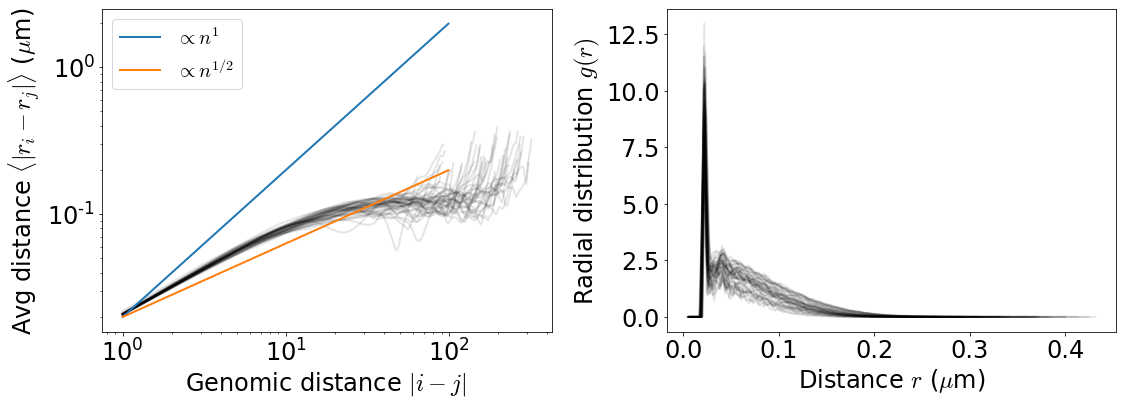

In [28]:

ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
t = -1000 # Snapshot time to use
fig, axarr = plt.subplots(1,2, figsize=(16, 6))


for i, clust in enumerate(clusters[t]):
    cli = clust.part_ids
    # if len(cli) < 100 or len(cli) > 250:
    if len(cli) < 50:
        continue
    clust_ind_com = com_arr[cli,:,t]
    # print(clust_ind_com )
    hull = ConvexHull(clust_ind_com)
    # print(f"Volume of condensate: {1e9*hull.volume} nm$^3$")
    # print(f"Volume per bead: {1e9*hull.volume/float(clust_ind_com.shape[0])} nm$^3$")

    warnings.filterwarnings('ignore')
    avg_dist_arr, avg_dist_sem_arr = dist_vs_idx_dist(clust_ind_com) 
    # print(avg_dist_arr)
    dist_mat = np.linalg.norm((clust_ind_com[:, np.newaxis, :] -
                            clust_ind_com[np.newaxis, :, :]),
                            axis=2)
    rad_distr_func, rad_bin_edges = ca.rad_distr_func_at_t(dist_mat, hist_max=1.1*np.max(dist_mat))

    # _ = axarr[0].errorbar(np.arange(len(avg_dist_arr)), avg_dist_arr, yerr=avg_dist_sem_arr, label=f'cluster {i}')
    _ = axarr[0].plot(np.arange(1,len(avg_dist_arr)), avg_dist_arr[1:], c='k', alpha=.1)
    _ = axarr[1].plot(rad_bin_edges[2:], rad_distr_func[1:]*hull.volume,  c='k', alpha=.1)

_ = axarr[0].plot(np.arange(1,100), .02*np.arange(1,100), label=r"$\propto n^{1}$")
_ = axarr[0].plot(np.arange(1,100), .02*np.sqrt(np.arange(1,100)), label=r"$ \propto n^{1/2}$")

_ = axarr[0].set_yscale("log")
_ = axarr[0].set_xscale("log")
# _ = axarr[1].set_yscale("log")
# _ = axarr[1].axvline(.02, color='r')
# _ = axarr[1].axvline(.05, color='r')


_ = axarr[0].set_xlabel(r"Genomic distance $|i - j|$ ")
_ = axarr[0].set_ylabel(r"Avg distance $\langle |r_i - r_j|\rangle$ ($\mu$m)")
_ = axarr[1].set_xlabel(r"Distance $r$ ($\mu$m)")
_ = axarr[1].set_ylabel(r"Radial distribution $g(r)$")

# _ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr[0].legend()
fig.tight_layout()

In [14]:
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=20)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

451936


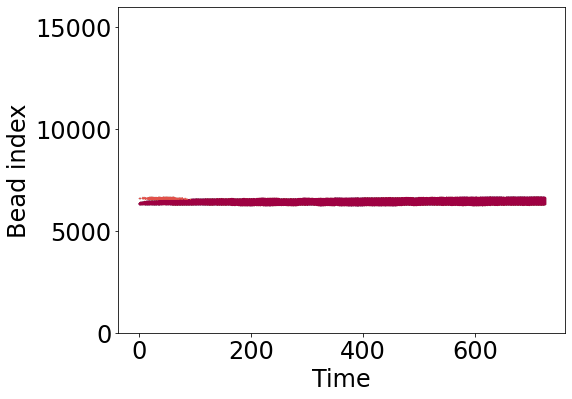

In [15]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,16000)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
print(biggest_tree.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(branch_roots))]
for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    if len(branch_clusters) < 20:
        continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [16]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
colors = [plt.cm.Spectral(tree) for tree in np.linspace(0, 1, len(trees))]
for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

## Sticky patch free polymer

In [27]:
data_path = (ceph_path /"22-07-12_aLc1_line16000_sticky_100um_patch1e3")

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None

# Get bead position information
with h5py.File(next(data_path.glob('analysis/22*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

# Get cluster information
h5_clust_file = (data_path / 'analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]



(1649,)


number of estimated clusters : 313
number of thresholded clusters : 56


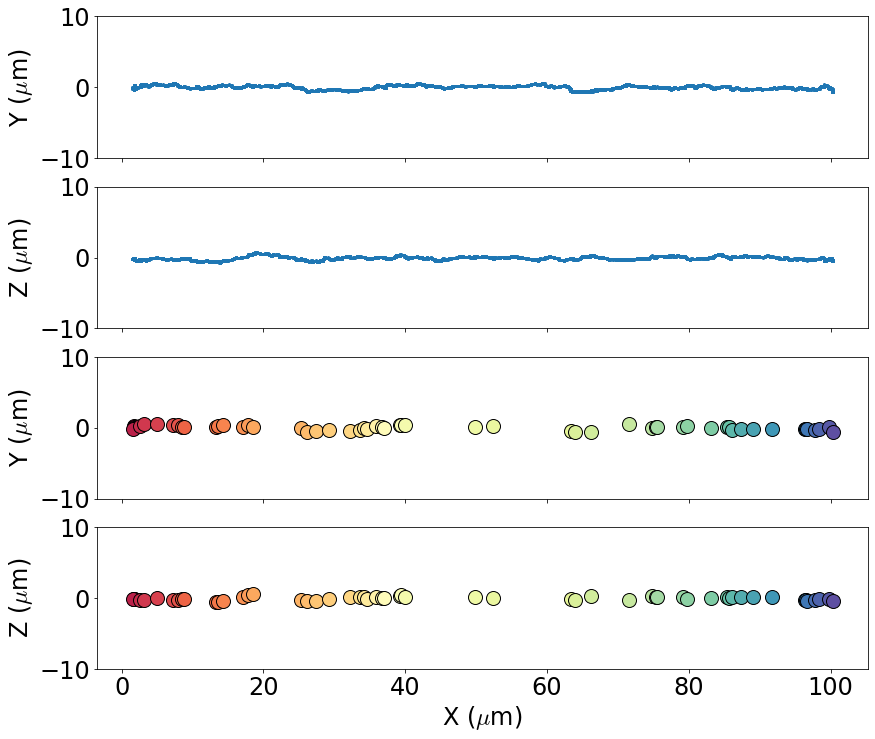

In [18]:
clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
    com_arr[:, :, -1])

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
_ = cgf.graph_clust_snapshot(fig, axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)

for ax in axarr:
    _ = ax.set_ylim(-10,10)

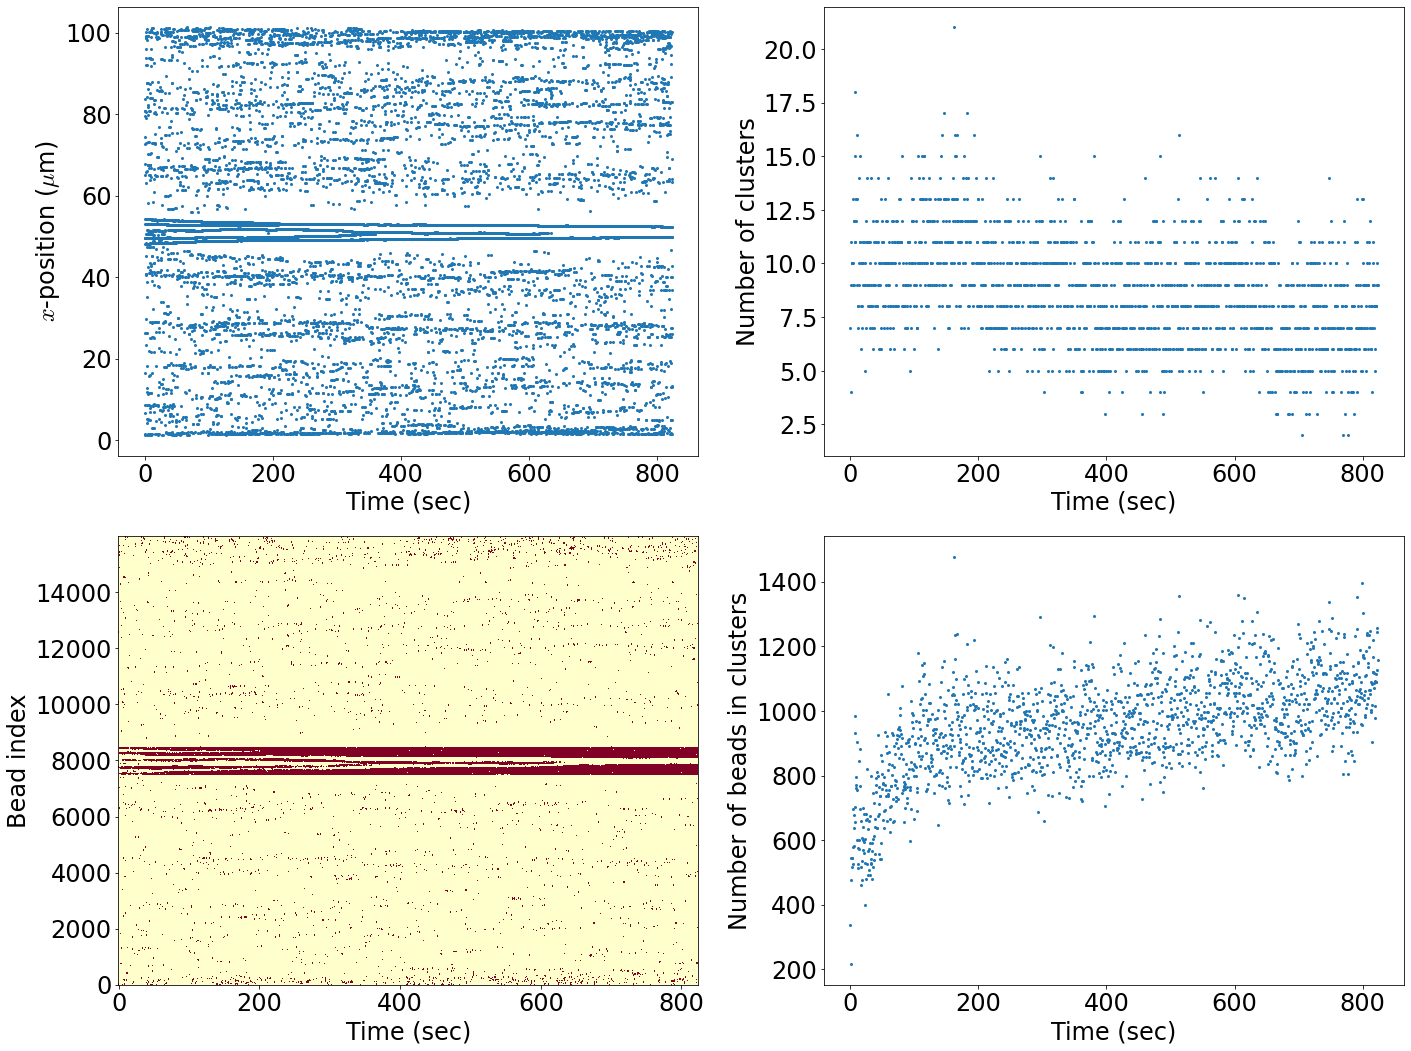

In [28]:
flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []
num_clusters_list = []
num_cluster_beads_list = []

for c, clust_grp in enumerate(clusters):
    num_clusters_list += [len(clust_grp)]
    num_beads = 0
    for i, clust in enumerate(clust_grp):
        flat_time_arr += [clust.time]
        flat_clust_cent_arr += [clust.center]
        flat_clust_ind_arr += [clust.part_ids]
        num_beads += len(clust.part_ids)

    num_cluster_beads_list += [num_beads]
    
bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_grp in enumerate(clusters):
    for clust in clust_grp:
        bead_ind_arr[clust.part_ids,c] += one_mask[clust.part_ids]



fig, axarr = plt.subplots(2,2, figsize=(20, 15))
X, Y = np.meshgrid(time_arr, np.arange(bead_ind_arr.shape[0]))
c = axarr[1,0].pcolor(X, Y, bead_ind_arr, shading='nearest')

flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
_ = axarr[0,0].scatter(flat_time_arr, flat_clust_cent_arr[:,0])
_ = axarr[0,1].scatter(time_arr[:-1], num_clusters_list)
_ = axarr[1,1].scatter(time_arr[:-1], num_cluster_beads_list)
_ = axarr[0,0].set_ylabel('$x$-position ($\mu$m)')
_ = axarr[0,1].set_ylabel('Number of clusters')
_ = axarr[1,0].set_ylabel('Bead index')
_ = axarr[1,1].set_ylabel('Number of beads in clusters')
for ax in axarr.flatten():
    _ = ax.set_xlabel('Time (sec)')
fig.tight_layout()

1648


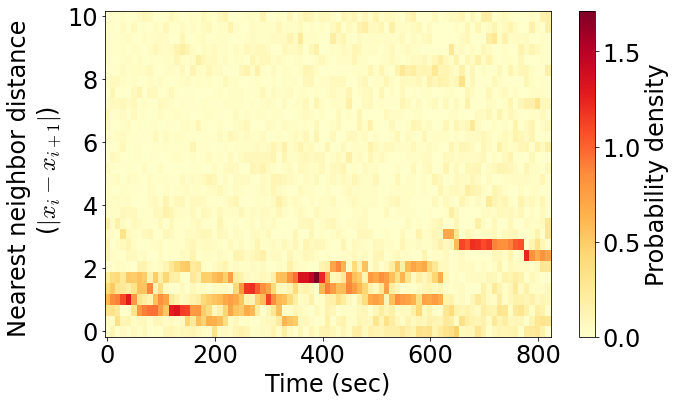

In [32]:
fig, axarr = plt.subplots(1,1, figsize=(10, 6))

N = 20 
sep_arr_list = []
print(len(clusters))
for i in range(0, len(clusters), N):
    cluster_centers = []
    for j in range(N):
        if i+j >= len(clusters):
            break
        time_grp = sorted(clusters[i+j], key=lambda x: x.center[0])
        cluster_centers += [c.center for c in time_grp] 

    cluster_centers = np.array(cluster_centers)
    sep_arr = cluster_centers[1:, 0] - cluster_centers[:-1, 0] 
    sep_arr_list += [sep_arr]

max_dist = 10
nbins = 30
hists = np.zeros((len(sep_arr_list), nbins)) 
for i, seps in enumerate(sep_arr_list):
    hists[i], bin = np.histogram(seps, bins=nbins, range=(0, max_dist),density=True)

T,X = np.meshgrid(time_arr[::N], np.linspace(0, max_dist, nbins))
c = axarr.pcolor(T,X, hists.T, shading='nearest')
cbar = fig.colorbar(c, ax=axarr, label='Probability density')
    

_ = axarr.set_ylabel("Nearest neighbor distance \n ($|x_i - x_{i+1}|$)") 
_ = axarr.set_xlabel("Time (sec)")

In [ ]:
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=20)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

451936


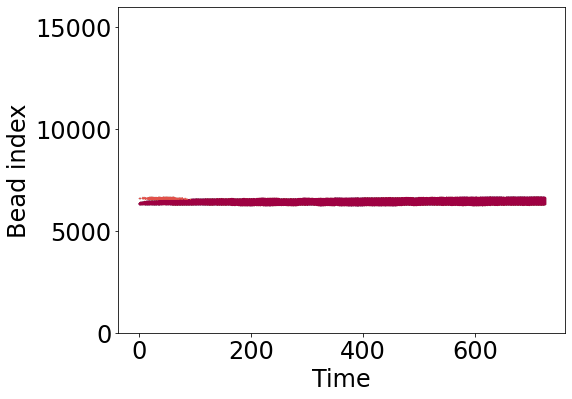

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,16000)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
print(biggest_tree.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(branch_roots))]
for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    if len(branch_clusters) < 20:
        continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
colors = [plt.cm.Spectral(tree) for tree in np.linspace(0, 1, len(trees))]
for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

/tmp/ipykernel_3456393/353349454.py:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axarr[1,0].pcolor(X, Y, bead_ind_arr)


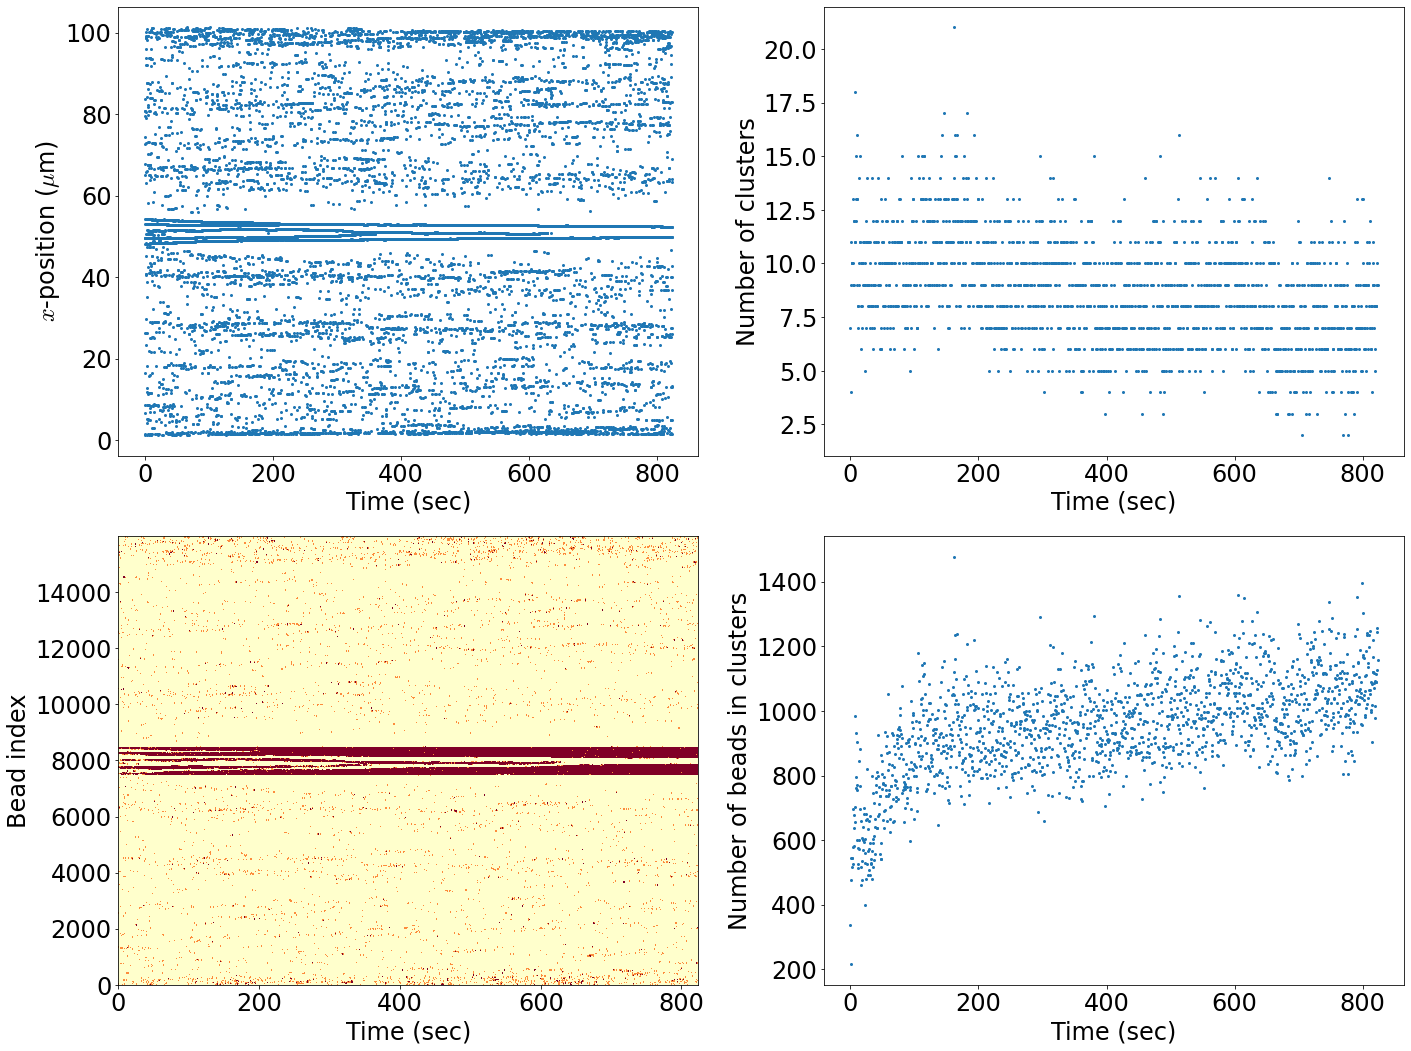

In [10]:
flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []
num_clusters_list = []
num_cluster_beads_list = []

for c, clust_grp in enumerate(clusters):
    num_clusters_list += [len(clust_grp)]
    num_beads = 0
    for i, clust in enumerate(clust_grp):
        if len(clust.part_ids) > 20:
            flat_time_arr += [clust.time]
            flat_clust_cent_arr += [clust.center]
            flat_clust_ind_arr += [clust.part_ids]
            num_beads += len(clust.part_ids)

    num_cluster_beads_list += [num_beads]
    
bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_grp in enumerate(clusters):
    for clust in clust_grp:
        bead_ind_arr[clust.part_ids,c] += one_mask[clust.part_ids]
bead_ind_arr[:,:-1] += bead_ind_arr[:,1:]
bead_ind_arr *= .5


fig, axarr = plt.subplots(2,2, figsize=(20, 15))
X, Y = np.meshgrid(time_arr, np.arange(com_arr.shape[0]))
c = axarr[1,0].pcolor(X, Y, bead_ind_arr)

flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
_ = axarr[0,0].scatter(flat_time_arr, flat_clust_cent_arr[:,0])
_ = axarr[0,1].scatter(time_arr[:-1], num_clusters_list)
#axarr[1,0].scatter(flat_time_arr, flat_clust_ind_arr)
_ = axarr[1,1].scatter(time_arr[:-1], num_cluster_beads_list)
_ = axarr[0,0].set_ylabel('$x$-position ($\mu$m)')
_ = axarr[0,1].set_ylabel('Number of clusters')
_ = axarr[1,0].set_ylabel('Bead index')
_ = axarr[1,1].set_ylabel('Number of beads in clusters')
for ax in axarr.flatten():
    _ = ax.set_xlabel('Time (sec)')
fig.tight_layout()

# Constructing a merger tree

In [4]:
data_path = (ceph_path /"22_aLchr700_sticky_runs/22-01-06_aLchr1_scan8.12_line700_2xsticky_4umconf_ko.1-300/simulations/kod1/s6")

In [27]:
# Get cluster data
# data_path = ceph_path / "22-07-15_aLc1_line16000_100umconf"
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
# data_path = (
#     ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                            :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust_cent_list = []
    clust_label_list = []
    for i in range(time_arr.size):
        clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
            com_arr[:, :, i], thresh=40)
        clust_cent_list += [cluster_centers]
        clust_label_list += [cluster_label_inds]

data_dict = {
    "time_arr": time_arr.tolist(),
    "cluster_center_list" : [[c.tolist() for c in t] for t in clust_cent_list],
    "cluster_label_list" : [[c.tolist() for c in t] for t in clust_label_list],
}


number of estimated clusters : 4
number of thresholded clusters : 0
number of estimated clusters : 9
number of thresholded clusters : 0
number of estimated clusters : 12
number of thresholded clusters : 1
number of estimated clusters : 9
number of thresholded clusters : 1
number of estimated clusters : 8
number of thresholded clusters : 1
number of estimated clusters : 9
number of thresholded clusters : 1
number of estimated clusters : 12
number of thresholded clusters : 1
number of estimated clusters : 14
number of thresholded clusters : 1
number of estimated clusters : 10
number of thresholded clusters : 2
number of estimated clusters : 10
number of thresholded clusters : 4
number of estimated clusters : 12
number of thresholded clusters : 1
number of estimated clusters : 10
number of thresholded clusters : 4
number of estimated clusters : 8
number of thresholded clusters : 3
number of estimated clusters : 11
number of thresholded clusters : 2
number of estimated clusters : 10
number

In [28]:
with (data_path / 'analysis/clust_data.yaml').open('w') as yf:
    yaml.dump(data_dict, yf)

In [5]:
with (data_path / 'analysis/clust_data.yaml').open('r') as yf:
    data_dict = yaml.safe_load(yf)
time_arr = np.array(data_dict['time_arr'])
cluster_center_list = data_dict['cluster_center_list']
cluster_label_list = data_dict['cluster_label_list']

In [ ]:

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_list[i]:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

root_clusters = cla.find_descendants(clusters, nskip=1)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


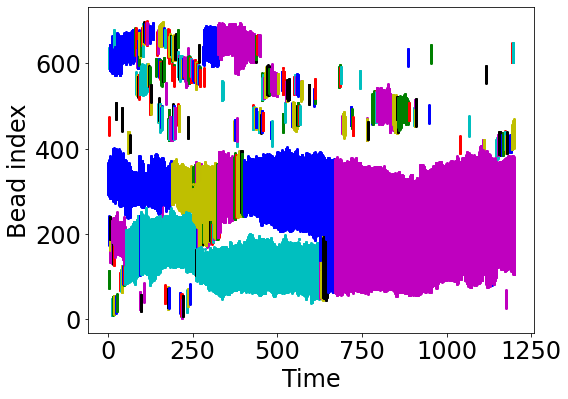

In [9]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color)

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [10]:

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_list[i]:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

root_clusters = cla.find_descendants(clusters, nskip=2)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


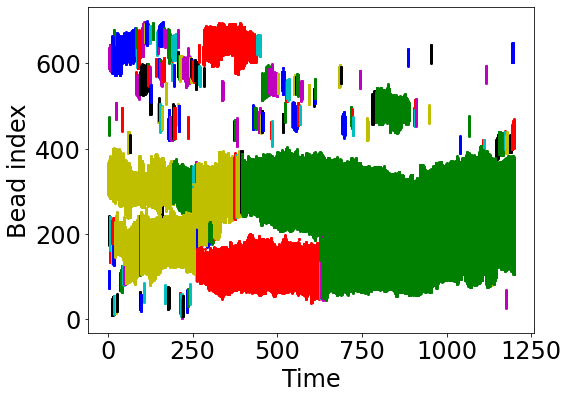

In [11]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color)

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [12]:

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_list[i]:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

root_clusters = cla.find_descendants(clusters, nskip=5)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


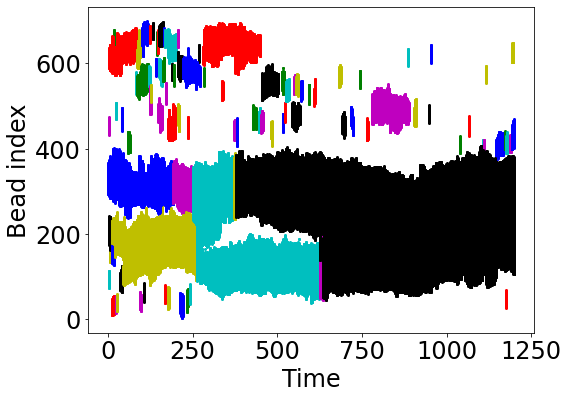

In [13]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color)

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [14]:

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_list[i]:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

root_clusters = cla.find_descendants(clusters, nskip=10)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


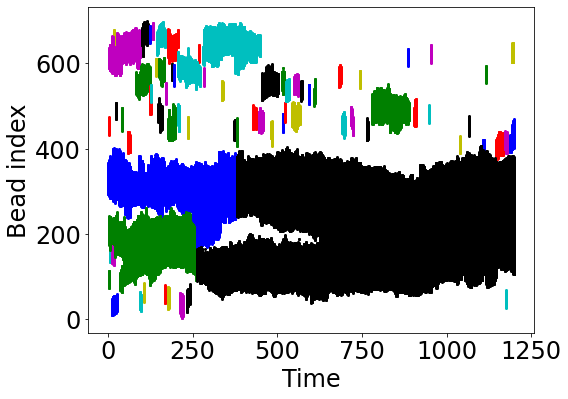

In [15]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color)

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [16]:

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_list[i]:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

root_clusters = cla.find_descendants(clusters, nskip=20)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


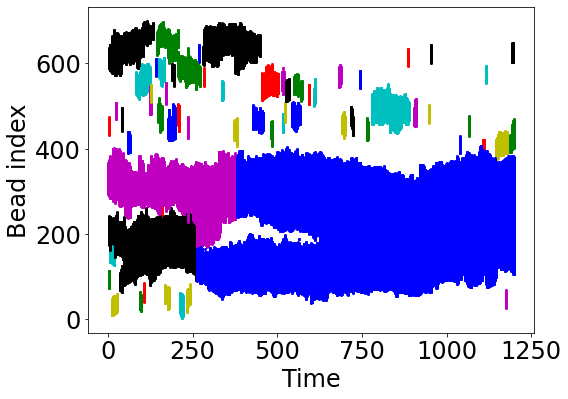

In [17]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color)

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [47]:

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_list[i]:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=40)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


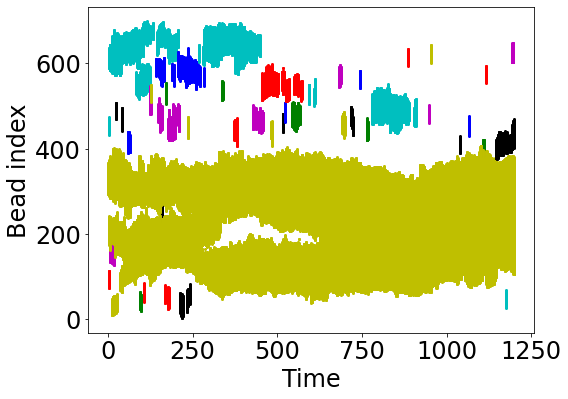

In [21]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color)

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

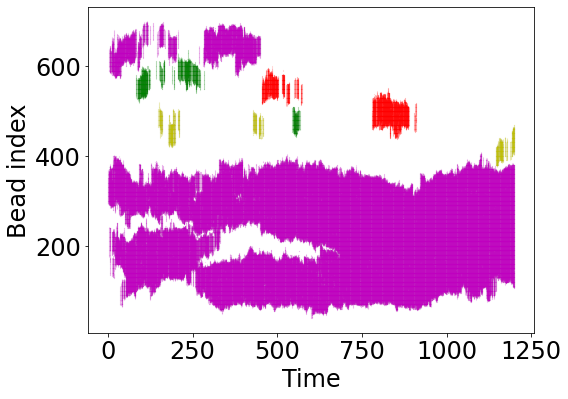

In [51]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

(0.0, 700.0)

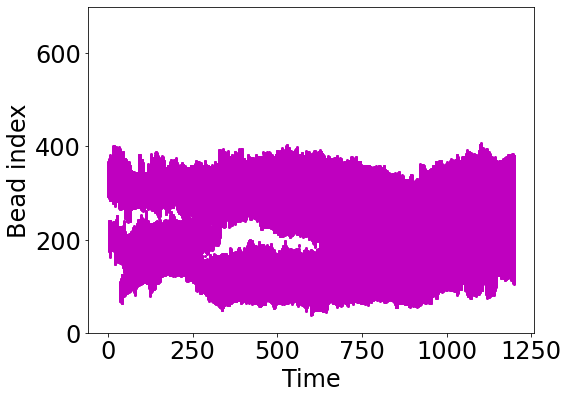

In [34]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)

for clust in biggest_tree.clusters:
    _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color)

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

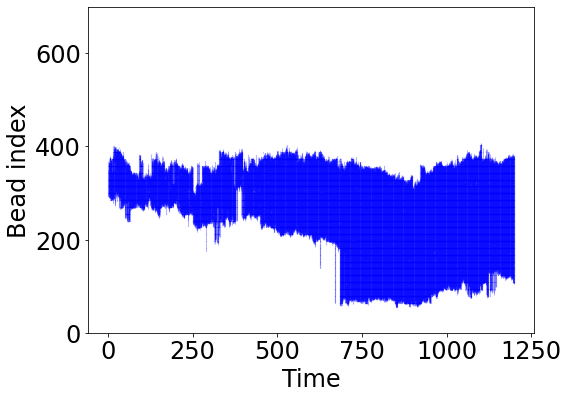

In [50]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_main_clust_branch()

for clust in biggest_tree.get_main_clust_branch():
    _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

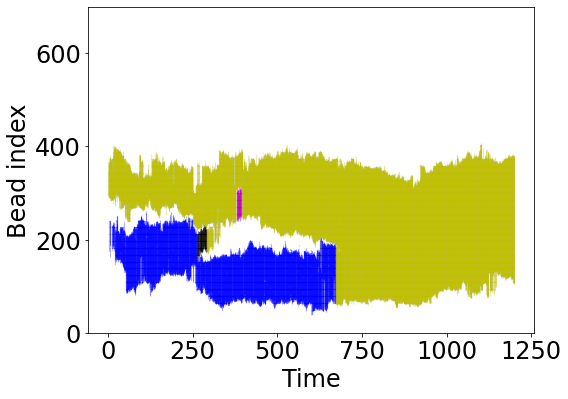

In [49]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    if len(branch_clusters) < 20:
        continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [7]:
data_path = (ceph_path /"21_aLchr1_700_runs/21-10-18_aLchr1_line700_2xsticky_conf")

In [53]:
# Get cluster data
# data_path = ceph_path / "22-07-15_aLc1_line16000_100umconf"
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
# data_path = (
#     ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                            :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust_cent_list = []
    clust_label_list = []
    for i in range(time_arr.size):
        clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
            com_arr[:, :, i], thresh=40)
        clust_cent_list += [cluster_centers]
        clust_label_list += [cluster_label_inds]

data_dict = {
    "time_arr": time_arr.tolist(),
    "cluster_center_list" : [[c.tolist() for c in t] for t in clust_cent_list],
    "cluster_label_list" : [[c.tolist() for c in t] for t in clust_label_list],
}
# Took 36m 27sec

number of estimated clusters : 4
number of thresholded clusters : 0
number of estimated clusters : 4
number of thresholded clusters : 0
number of estimated clusters : 8
number of thresholded clusters : 0
number of estimated clusters : 6
number of thresholded clusters : 0
number of estimated clusters : 9
number of thresholded clusters : 0
number of estimated clusters : 11
number of thresholded clusters : 0
number of estimated clusters : 12
number of thresholded clusters : 0
number of estimated clusters : 11
number of thresholded clusters : 0
number of estimated clusters : 14
number of thresholded clusters : 1
number of estimated clusters : 11
number of thresholded clusters : 0
number of estimated clusters : 10
number of thresholded clusters : 1
number of estimated clusters : 11
number of thresholded clusters : 1
number of estimated clusters : 12
number of thresholded clusters : 2
number of estimated clusters : 10
number of thresholded clusters : 2
number of estimated clusters : 12
numbe

In [54]:
with (data_path / 'analysis/clust_data.yaml').open('w') as yf:
    yaml.dump(data_dict, yf)

In [25]:
with (data_path / 'analysis/clust_data.yaml').open('r') as yf:
    data_dict = yaml.safe_load(yf)
time_arr = np.array(data_dict['time_arr'])
cluster_center_list = data_dict['cluster_center_list']
cluster_label_list = data_dict['cluster_label_list']

In [29]:

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_list[i]:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=50)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


In [13]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(12000)
print(sys.getrecursionlimit())

6000
12000


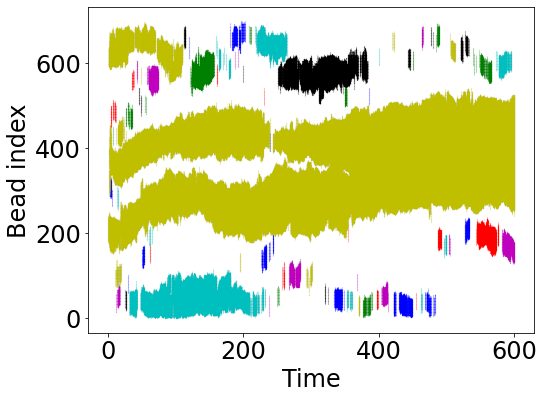

In [28]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color,s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

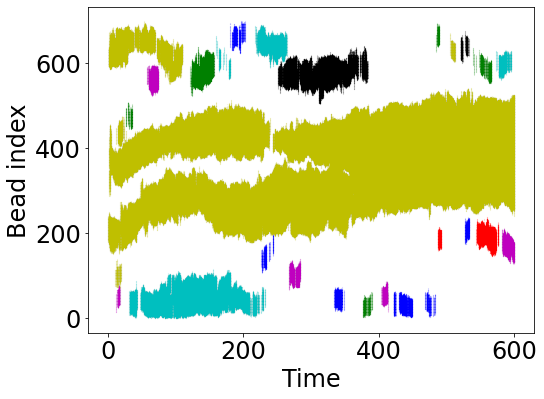

In [17]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

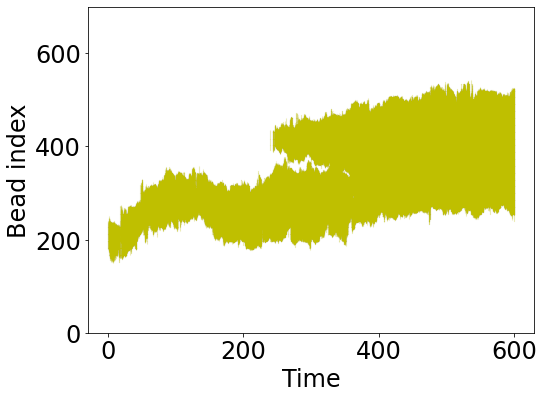

In [30]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)

for clust in biggest_tree.clusters:
    _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color,  s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

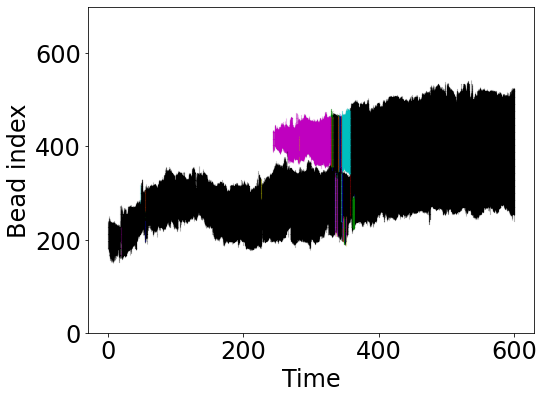

In [23]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    # if len(branch_clusters) < 20:
    #     continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

## Make cluster hdf5 file

In [6]:
t0 = time.time()
data_path = (ceph_path /"22-07-15_aLc1_line16000_100umconf")
with (data_path / 'analysis/clust_data.yaml').open('r') as yf:
    data_dict = yaml.safe_load(yf)
time_arr = np.array(data_dict['time_arr'])
cluster_center_list = data_dict['cluster_center_list']
cluster_label_list = data_dict['cluster_label_list']
t1 = time.time()
print(f'Read file {t1-t0}')

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds, clust_cent in zip(cluster_label_list[i], cluster_center_list):
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds, clust_cent)]
t2 = time.time()
print(f'Created clusters {t2-t1}')


Read file 136.5832076072693
Created clusters 0.06189441680908203


AttributeError: 'list' object has no attribute 'write_clust_to_hdf5_dset'

In [14]:
t2 = time.time()
h5_clust_file = (data_path /'analysis/clust_data.h5')
h5_clust_file.unlink()
with h5py.File(h5_clust_file, 'w') as h5_data:
    h5_data.create_dataset('time', data=time_arr)
    clust_grp = h5_data.create_group('clusters')
    for t, cg in zip(time_arr[1:], clusters[1:]):
        time_grp = clust_grp.create_group(f'time_{t}')
        time_grp.attrs['time'] = t
        for c in cg:
            c.write_clust_to_hdf5_dset(time_grp)
t3 = time.time()
print(f'Wrote clusters {t3-t2}')


<HDF5 dataset "time": shape (439,), type "<f8">

Wrote clusters 48.534268379211426


In [26]:
t3 = time.time()
data_path = (ceph_path /"22-07-15_aLc1_line16000_100umconf")
h5_clust_file = (data_path /'analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = [[]]
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
    # clust_grp = h5_data.create_group('clusters')
t4 = time.time()
print(f'Read clusters {t4-t3}')


Read clusters 8.417649030685425


In [27]:
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=40)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

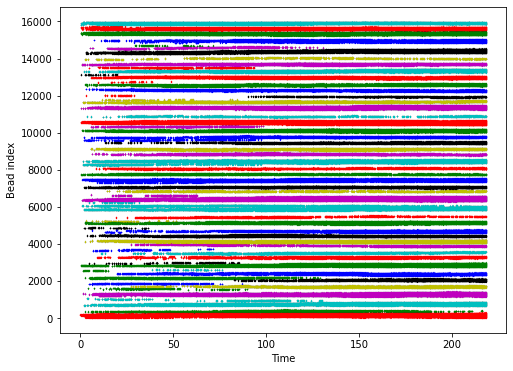

In [28]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [90]:
h5_clust_file = (ws_path/ '22-04-01_aLchr1_scan.12_line700_2xsticky_rigid700_5umconf/simulations/s6/analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
    # clust_grp = h5_data.create_group('clusters')
t4 = time.time()
#print(f'Read clusters {t4-t3}')
#print(clusters)
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=40)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]



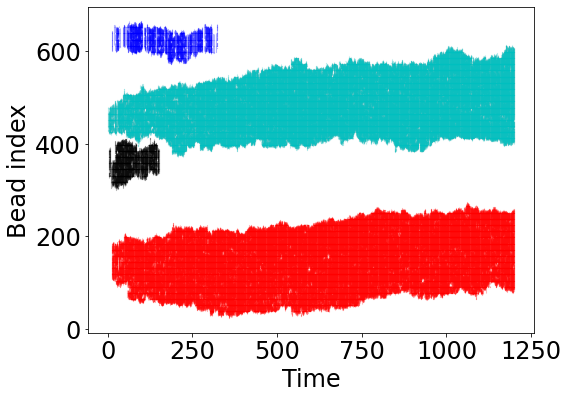

In [91]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

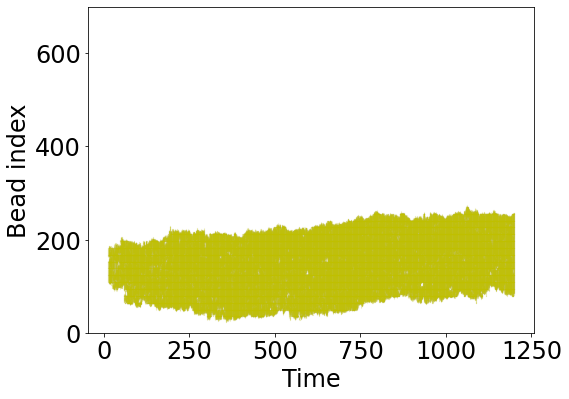

In [80]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    # if len(branch_clusters) < 20:
    #     continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [82]:
h5_clust_file = (ceph_path/ '22_aLchr700_sticky_runs/22-01-06_aLchr1_scan8.12_line700_2xsticky_4umconf_ko.1-300/simulations/kod300/s1/analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
    # clust_grp = h5_data.create_group('clusters')
t4 = time.time()
#print(f'Read clusters {t4-t3}')
#print(clusters)
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=40)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]



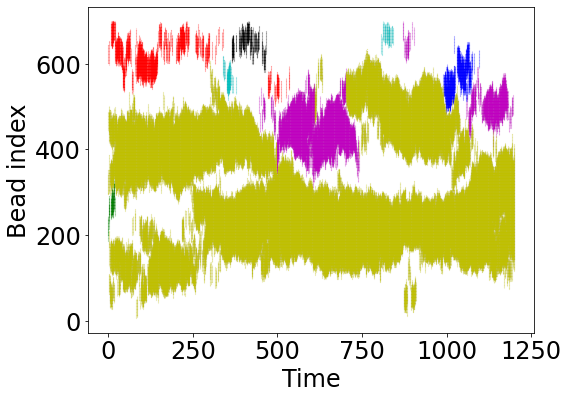

In [83]:

fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

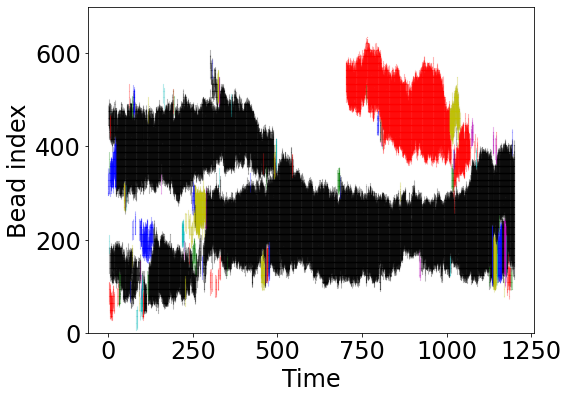

In [84]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    # if len(branch_clusters) < 20:
    #     continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [87]:
h5_clust_file = (ws_path/ '22-04-01_aLchr1_scan.12_line700_2xsticky_rigid700_5umconf/simulations/s12/analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
    # clust_grp = h5_data.create_group('clusters')
t4 = time.time()
#print(f'Read clusters {t4-t3}')
#print(clusters)
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=40)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


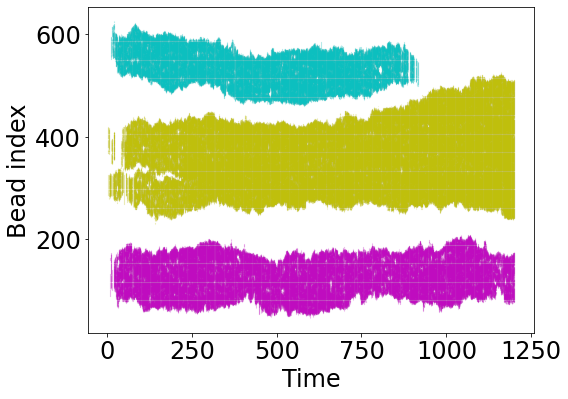

In [88]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

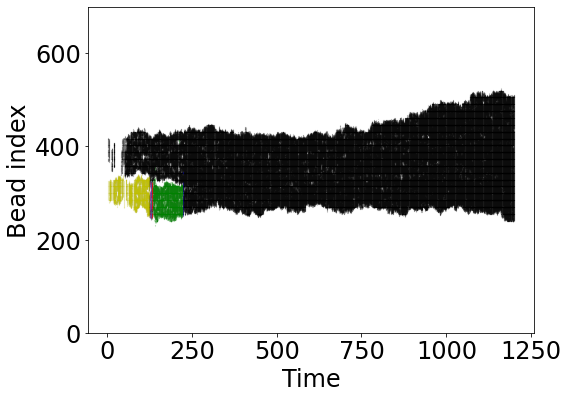

In [89]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    # if len(branch_clusters) < 20:
    #     continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

# Testing

StopIteration: 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


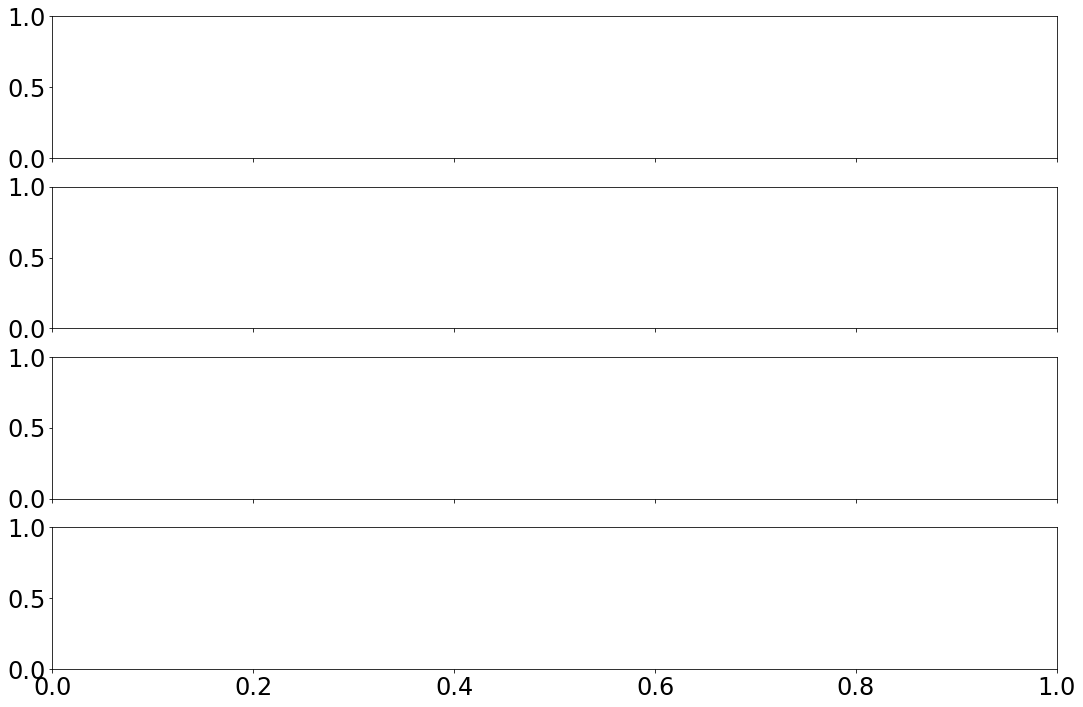

In [4]:
data_path = (ceph_path /"22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
   
    _ =axarr[0].scatter(com_arr[:,0,-1], com_arr[:,1,-1])
    _ =axarr[1].scatter(com_arr[:,0,-1], com_arr[:,2,-1])
    _ =axarr[0].set_ylabel('Y ($\mu$m)')
    _ =axarr[1].set_ylabel('Z ($\mu$m)')
    _ =axarr[3].set_xlabel('X ($\mu$m)')
    
    X = com_arr[:,:,-1]
    
    db = DBSCAN(eps=0.05, min_samples=15).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print("number of estimated clusters : %d" % n_clusters_)

    # Collect a list of cluster centers and the list of their labels
    cluster_centers = []
    cluster_label_inds = []
    for k in range(n_clusters_):
        cli = np.where(labels == k)[0]
        if cli.size < 50:
            continue
        cluster_label_inds += [ cli ]
        cluster_centers += [X[cli,:].mean(axis=0)]
    
    # Plot all the particles in the cluster and the cluster centers
    for k, col in zip(range(n_clusters_), colors):
        my_members = labels == k
        cluster_center = cluster_centers[k]
        _ = axarr[2].scatter(X[my_members, 0], X[my_members, 1], color=col)
        _ = axarr[2].plot(
            cluster_center[0],
            cluster_center[1],
            "o",
            markerfacecolor=col,
            markeredgecolor="k",
            markersize=14,
        )
        _ = axarr[3].scatter(X[my_members, 0], X[my_members, 2], color=col)
        _ = axarr[3].plot(
            cluster_center[0],
            cluster_center[2],
            "o",
            markerfacecolor=col,
            markeredgecolor="k",
            markersize=14,
        )

    for ax in axarr:
        _ = ax.set_aspect(1)
    

# Depricated

(199,)
number of estimated clusters : 45
number of thresholded clusters : 37
number of estimated clusters : 39
number of thresholded clusters : 34
number of estimated clusters : 37
number of thresholded clusters : 34
number of estimated clusters : 35
number of thresholded clusters : 34
number of estimated clusters : 37
number of thresholded clusters : 35


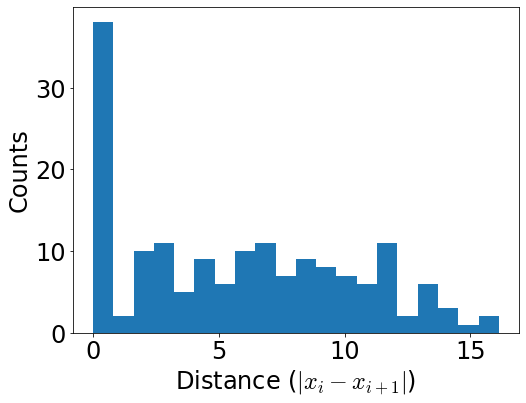

In [ ]:
data_path = (ceph_path /"22-07-15_aLc1_line16000_100umconf")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

ss_ind = -200
end_ind = -1

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    # analysis_grp = h5_data['analysis']
    print(time_arr.shape)

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    sep_arr = np.array([])
    N = 5
    for i in range(0,N):
        diff = int(time_arr.size / N)
        clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
            com_arr[:, :, diff*i])
        cluster_centers = np.array(cluster_centers)
        sep_mat = cluster_centers[:, np.newaxis, 0] - cluster_centers[np.newaxis, :, 0] 
        sep_arr = np.concatenate((sep_arr, np.abs(np.diagonal(sep_mat,i))))
    _ = axarr.hist(sep_arr, bins=20)
    _ = axarr.set_ylabel("Counts")
    _ = axarr.set_xlabel("Distance ($|x_i - x_{i+1}|$)") 


/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


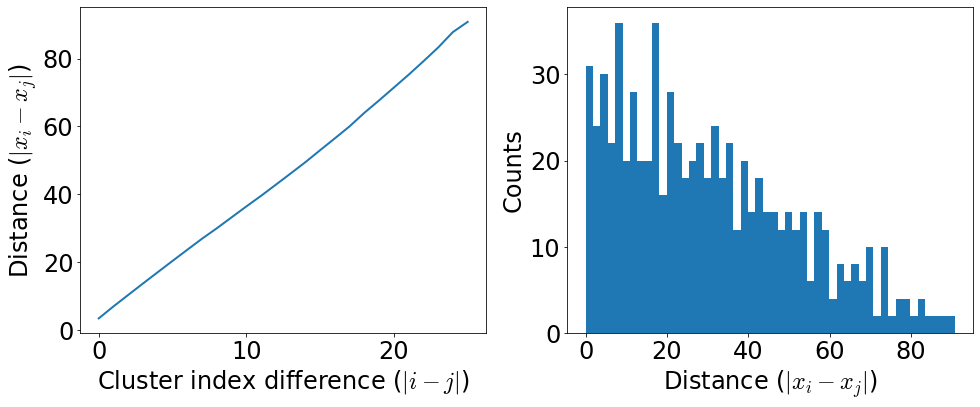

In [ ]:
data_path = (ws_path /"22-07-12_aLc1_line16000_sticky_100um")
ss_ind = 0
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    # analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
com_arr[:, :, -1])

clust_cen_arr = np.array(sorted(cluster_centers, key = lambda x: x[0]))

sep_mat = clust_cen_arr[:, np.newaxis, 0] - clust_cen_arr[np.newaxis, :, 0] 
avg_dist_arr = [] 
avg_dist_sem_arr = []
fig, axarr = plt.subplots(1,2, figsize=(16, 6))

for i in range(1,sep_mat.shape[0]):
        diag = np.diagonal(sep_mat, i)
        avg_dist_arr += [diag.mean()]
        avg_dist_sem_arr += [stats.sem(diag)]
        
_ = axarr[0].plot(np.abs(avg_dist_arr))
_ = axarr[0].set_ylabel("Distance ($|x_i - x_j|$)")
_ = axarr[0].set_xlabel("Cluster index difference ($|i-j|$)")
_ = axarr[1].hist(np.abs(sep_mat.flatten()), bins=50)
_ = axarr[1].set_ylabel("Counts")
_ = axarr[1].set_xlabel("Distance ($|x_i - x_j|$)")

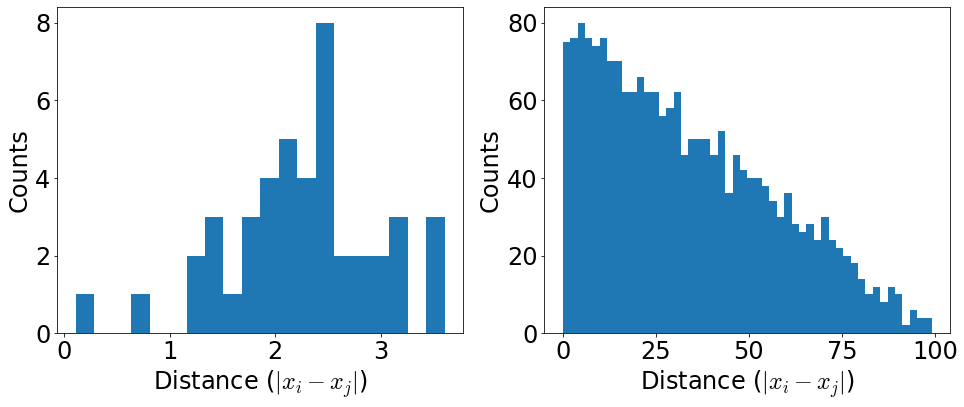

In [ ]:
clust_cen_arr = np.array(sorted(cluster_centers, key = lambda x: x[0]))

sep_mat = clust_cen_arr[:, np.newaxis, 0] - clust_cen_arr[np.newaxis, :, 0] 
avg_dist_arr = [] 
avg_dist_sem_arr = []
fig, axarr = plt.subplots(1,2, figsize=(16, 6))

diag = np.abs(np.diagonal(sep_mat, 1))
        
_ = axarr[0].hist(diag, bins=20)
_ = axarr[0].set_ylabel("Counts")
_ = axarr[0].set_xlabel("Distance ($|x_i - x_j|$)")
_ = axarr[1].hist(np.abs(sep_mat.flatten()), bins=50)
_ = axarr[1].set_ylabel("Counts")
_ = axarr[1].set_xlabel("Distance ($|x_i - x_j|$)")

## Clusters over time

30.661806344985962
0.30661806344985965


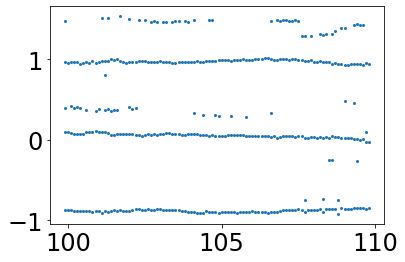

In [ ]:
data_path = (ceph_path /"21-12-05_aLchr1_scan.12_line700_2xsticky_3umconf/simulations/s10")
ss_ind = 1000
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in range(100):
        t0 = time.time()
        X = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(X)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 20:
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [X[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

34.89495635032654
0.3489495635032654


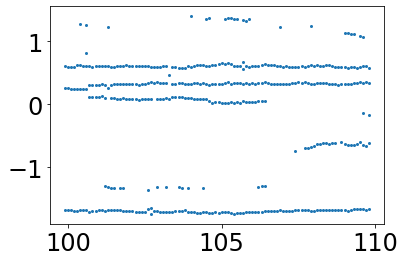

In [ ]:
data_path = (ceph_path /"21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations/s6")
ss_ind = 600
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in range(1000):
        t0 = time.time()
        X = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(X)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 20:
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [X[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


623.9818077087402
0.3119909038543701


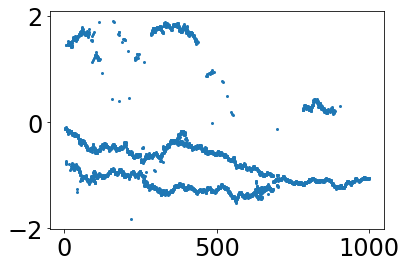

In [ ]:
data_path = (ceph_path /"22-01-06_aLchr1_scan8.12_line700_2xsticky_4umconf_ko.1-300/simulations/kod1/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in range(2000):
        t0 = time.time()
        X = com_arr[:,:,i]
        cluster_centers = []

        # Run OPTICS: min_sample=
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(X)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 50:
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [X[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
time_clust = OPTICS(min_samples=10, eps=0.1, cluster_method='dbscan')
time_scale = .005    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

### Center clustering in the time dimension

number of estimated clusters : 5


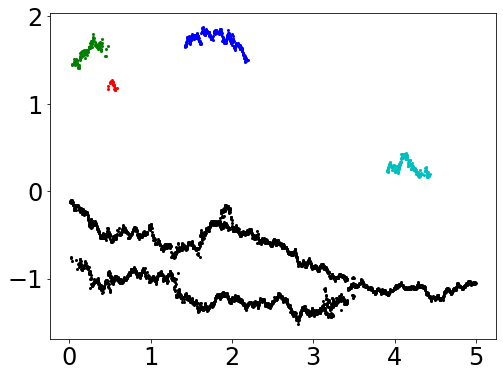

In [ ]:
time_clust = OPTICS(min_samples=10, eps=0.1, cluster_method='dbscan')
time_scale = .005
flat_time_arr = np.asarray(flat_time_arr)
time_space_clust_cent_arr = np.hstack((time_scale * flat_time_arr[:,np.newaxis], flat_clust_cent_arr))


_ = time_clust.fit(time_space_clust_cent_arr)
labels = time_clust.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("number of estimated clusters : %d" % n_clusters_)

fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    n_members = np.where(labels == k)[0].size
    # print(np.where(labels == k)[0].size)
    if n_members < 5:
        continue
    
    #cluster_center = cluster_centers[k]
    _ = axarr.scatter(time_space_clust_cent_arr[my_members, 0], time_space_clust_cent_arr[my_members, 1], color=col)

#     _ = axarr[3].scatter(X[my_members, 0], X[my_members, 2], color=col)
# for k, col in zip(range(n_



number of estimated clusters : 5


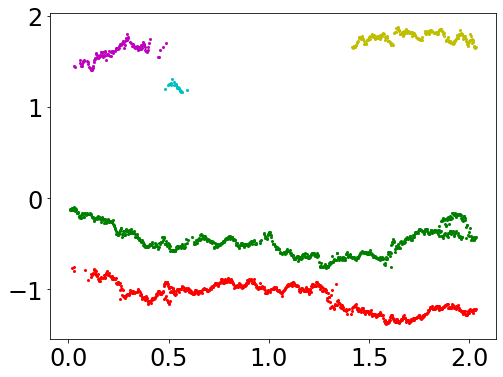

In [ ]:
time_clust = OPTICS(min_samples=10, eps=0.1, cluster_method='dbscan')
time_scale = .005
flat_time_arr = np.asarray(flat_time_arr)
time_space_clust_cent_arr = np.hstack((time_scale * flat_time_arr[:,np.newaxis], flat_clust_cent_arr))[:2000]


_ = time_clust.fit(time_space_clust_cent_arr)
labels = time_clust.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("number of estimated clusters : %d" % n_clusters_)

fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    n_members = np.where(labels == k)[0].size
    # print(np.where(labels == k)[0].size)
    if n_members < 5:
        continue
    
    #cluster_center = cluster_centers[k]
    _ = axarr.scatter(time_space_clust_cent_arr[my_members, 0], time_space_clust_cent_arr[my_members, 1], color=col)

#     _ = axarr[3].scatter(X[my_members, 0], X[my_members, 2], color=col)
# for k, col in zip(range(n_



743.3069474697113
0.37165347373485563


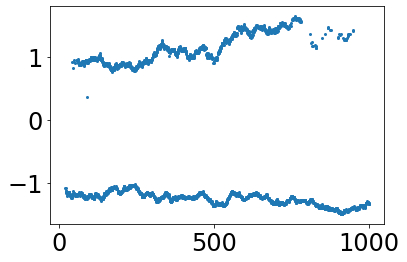

In [ ]:
data_path = (ceph_path /"22-04-15_aLchr1_scan7.12_line800_stickyL.01-.07_eps1_Ke30_5umconf/simulations/Ls0.07/s1")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in tqdm(range(2000)):
        t0 = time.time()
        X = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(X)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 50:
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [X[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

  0%|          | 0/2000 [00:00<?, ?it/s]

760.0616588592529
0.38003082942962646


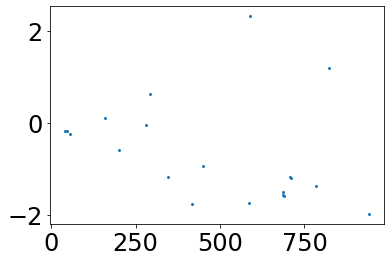

In [ ]:
data_path = (ceph_path /"22-04-15_aLchr1_scan7.12_line800_stickyL.01-.07_eps1_Ke30_5umconf/simulations/Ls0.01/s1")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in tqdm(range(2000)):
        t0 = time.time()
        coms = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(coms)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 50: # Threshold cluster size
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [coms[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

In [ ]:
data_path = (ws_path / "22-04-01_aLchr1_scan.12_line700_2xsticky_rigid700_5umconf/simulations/s7")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in tqdm(range(2000)):
        t0 = time.time()
        coms = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(coms)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 50: # Threshold cluster size
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [coms[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

  0%|          | 0/2000 [00:00<?, ?it/s]

NameError: name 'OPTICS' is not defined

2.0


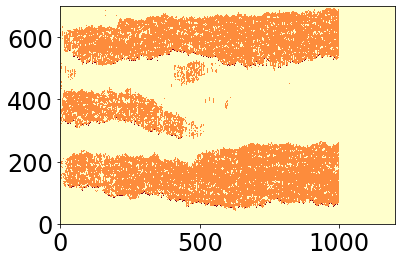

In [ ]:

bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_cli_grp in enumerate(cluster_lst):
    for cli in clust_cli_grp:
        bead_ind_arr[cli[0],c] += one_mask[cli[0]]

X, Y = np.meshgrid(time_arr, np.arange(com_arr.shape[0]))
plt.pcolor(X, Y, bead_ind_arr)

  0%|          | 0/2000 [00:00<?, ?it/s]

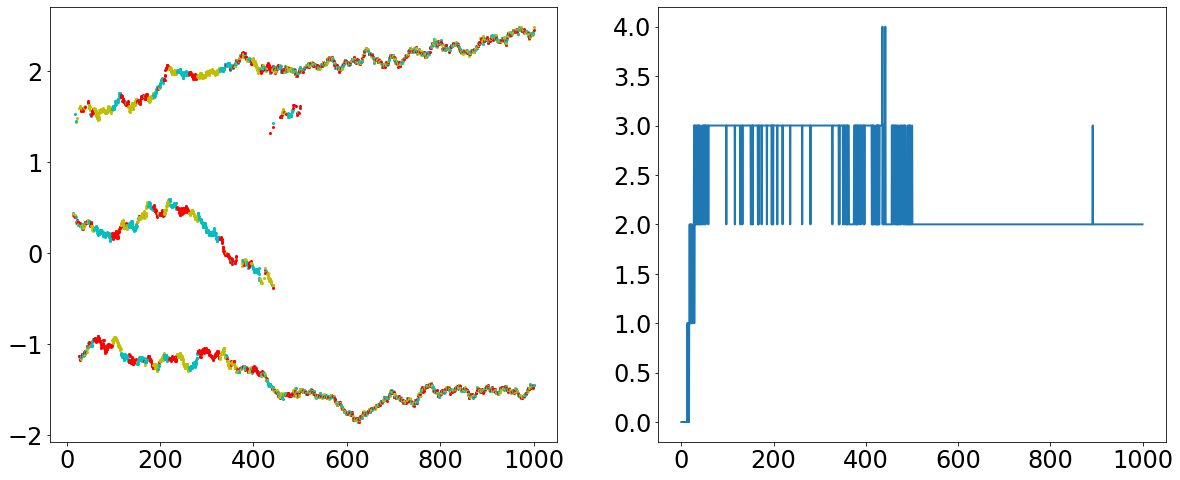

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(20, 8))

colors = cycle("rcy")
clust_num_arr = []
for c, clust_grp in tqdm(enumerate(cluster_center_lst), total=len(cluster_center_lst)):
    clust_num_arr += [len(clust_grp)]
    for (clust_cent, col) in zip(clust_grp,colors):
        _ = axarr[0].scatter(time_arr[c], clust_cent[0], color=col)
_ = axarr[1].plot(time_arr[:len(clust_num_arr)], clust_num_arr)
        

In [ ]:
clusters = [ [cluster[0]] for cluster in cluster_lst[100] if isinstance(cluster[0], np.ndarray)]
#print(clusters)
for cluster in tqdm(cluster_lst[100:], total = len(cluster_lst[100:])):
    for oc in clusters:
        if float(np.intersect1d(oc[-1], cluster[0]).size/len(oc[-1]))> .75:
            oc += [cluster[0]]


  0%|          | 0/1900 [00:00<?, ?it/s]

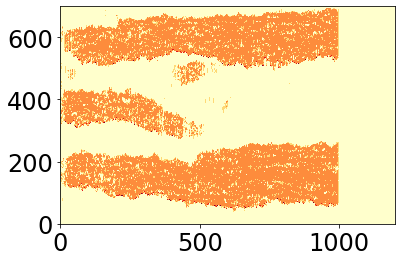

In [ ]:
bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_cli_grp in enumerate(cluster_lst):
    for cli in clust_cli_grp:
        bead_ind_arr[cli[0],c] += one_mask[cli[0]]
bead_ind_arr[:,:-1] += bead_ind_arr[:,1:]
bead_ind_arr *= .5
X, Y = np.meshgrid(time_arr, np.arange(com_arr.shape[0]))
plt.pcolor(X, Y, bead_ind_arr)